# Explore the CVI data 

We write code to explore the data outputs we've created in previous notebooks. 

Let's start by getting some information at NMEAD zone and island-wide level. 

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Negociado para el Manejo de Emergencias y Administracion de Desastres

This notebook contains code used to obtain the fourteen variables used to compute CVI, aggregated at NMEAD operational zone level or island-wide level. 

In [2]:
def get_data(geo):
    '''
    input: geo (barrios, municipios, or tracts)
    outputs: pandas DataFrame with limited CVI data for selected geographic level,
             with null CVI rows dropped.
    '''
    # select 
    df = pd.read_csv(FN_GEO[geo], encoding='ISO-8859-1')
    return df.dropna()

def get_municipio_to_zone_dictionary(fn, sheetname):
    '''
    Outputs a dictionary mapping municipios to NMEAD Operational Zones.
    '''
    zones = pd.read_excel(fn, sheet_name = sheetname) 
    return {k:v for k,v in zip(zones['NAME'].str.strip(), zones['Zone Name'])}

def get_selected_columns(geo):
    '''
    Outputs a list of variables selected for a particular geographic level.
    '''
    selected_columns = {'municipios': ['GEOID', 'zone', 'municipio', 
                                       'CVI', 'sum_of_all_rank_percentiles'], 
                        'barrios': ['GEOID', 'zone', 'municipio', 'barrio', 
                                    'CVI', 'sum_of_all_rank_percentiles'],
                        'tracts': ['GEOID', 'zone', 'municipio', 'tracts', 
                                   'CVI', 'sum_of_all_rank_percentiles']}
    
    return  selected_columns[geo]

def get_municipio_names_and_zones(df, geo):
    '''
    Extract municipio from 'NAME' column and apply municipio-to-zone map to get the zone the row
    of data belongs to.
    
    Outputs a pandas DataFrame with NMEAD Operational Zone column containing the operational zone
    the municipio, barrio, or census tract belong to. 
    '''
    if geo == 'municipios':
        municipios = df['NAME']
        df['municipio'] = municipios.str.split(' Municipio,').apply(lambda x: x[0])
        
    elif geo == 'barrios':
        barrios = df['NAME']
        barrios = barrios.str.split(',')
        df['barrio'] = barrios.apply(lambda x: x[0])
        df['municipio'] = barrios.apply(lambda x: x[1])
        df['municipio'] = df['municipio'].str.split(' Municipio').apply(lambda x: x[0].strip())
        
    elif geo == 'tracts':
        tracts = df['NAME']
        tracts = tracts.str.split(',')
        df['tracts'] = tracts.apply(lambda x: x[0])
        df['municipio'] = tracts.apply(lambda x: x[1])
        df['municipio'] = df['municipio'].str.split(' Municipio').apply(lambda x: x[0].strip())
    
    df['zone'] = df['municipio'].apply(lambda x: municipio_to_zone_dict[x])
    
    return df 

def reduce_df_size(df, geo):
    selected_columns = get_selected_columns(geo)
    smaller_df = df[selected_columns]
    smaller_df.sort_values(by='zone', inplace=True)
    smaller_df.reset_index(drop=True, inplace=True)
    return smaller_df

def get_cvi_data(geo):
    df = get_data(geo)
    df = get_municipio_names_and_zones(df, geo)
    df = reduce_df_size(df, geo)
    return df

def get_unique_zones(df):
    return df['zone'].unique().tolist()

In [3]:
# Outputs we've generated upon running previous notebooks
FN_GEO = {'barrios': '../outputs/cvi_data_for_barrios_2021.csv', 
          'municipios': '../outputs/cvi_data_for_municipios_2021.csv',
          'tracts': '../outputs/cvi_data_for_tracts_2021.csv'} 

# This file contains a table mapping all 78 municipios in Puerto Rico to one of ten NMEAD Operational Zones
FN_ZONES = '../inputs/NMEAD zones 2022-2023.xlsx'
SHEETNAME = 'Sheet1'

Get municipio to zone dictionary: 

In [4]:
municipio_to_zone_dict = get_municipio_to_zone_dictionary(FN_ZONES, SHEETNAME)

There are 10 operational zones in the Negociado para el Manejo de Emergencias y Administracion de Desastres (NMEAD).  

How many municipios are there in each zone? 

In [5]:
df1 = get_cvi_data('municipios')
df1.groupby('zone').count()['municipio']

zone
Aguadilla     7
Arecibo       7
Caguas        7
Ceiba        10
Guayama       8
Humacao       7
Mayagüez      8
Ponce         9
San Juan      7
Vega Baja     8
Name: municipio, dtype: int64

How many barrios are there in each zone? 

In [6]:
df2 = get_cvi_data('barrios')
df2.groupby('zone').count()['barrio']

zone
Aguadilla    112
Arecibo       87
Caguas        66
Ceiba         71
Guayama       81
Humacao       72
Mayagüez      88
Ponce        126
San Juan      61
Vega Baja     81
Name: barrio, dtype: int64

How many census tracts are there in each zone?

In [7]:
df3 = get_cvi_data('tracts')
df3.groupby('zone').count()['tracts']

zone
Aguadilla     65
Arecibo       61
Caguas        72
Ceiba        115
Guayama       53
Humacao       61
Mayagüez      66
Ponce         99
San Juan     270
Vega Baja     57
Name: tracts, dtype: int64

Create a dataframe containing these three series as columns. 
- Dataframe of number of geographies in each zone by zone. 

In [8]:
pd.DataFrame(df1.groupby('zone').count()['municipio']).join(pd.DataFrame(df2.groupby('zone').count()['barrio'])).join(pd.DataFrame(df3.groupby('zone').count()['tracts']))

municipio  barrio  tracts
zone                                
Aguadilla          7     112      65
Arecibo            7      87      61
Caguas             7      66      72
Ceiba             10      71     115
Guayama            8      81      53
Humacao            7      72      61
Mayagüez           8      88      66
Ponce              9     126      99
San Juan           7      61     270
Vega Baja          8      81      57

Create a dataframe containing the mean CVI per zone at municipio level, barrio level, and census tract level. 
- Dataframe of mean CVI in each zone by zone.

In [9]:
pd.DataFrame(df1.groupby('zone').mean()['CVI']).join(pd.DataFrame(df2.groupby('zone').mean()['CVI']), lsuffix = '_municipio', rsuffix='_barrios').join(pd.DataFrame(df3.groupby('zone').mean()['CVI']))

CVI_municipio  CVI_barrios       CVI
zone                                           
Aguadilla       0.262821     0.409716  0.429823
Arecibo         0.347070     0.446378  0.460738
Caguas          0.619048     0.546943  0.536294
Ceiba           0.408974     0.522602  0.455978
Guayama         0.596154     0.474987  0.533065
Humacao         0.465201     0.464555  0.426711
Mayagüez        0.532853     0.493895  0.530278
Ponce           0.638177     0.510219  0.556666
San Juan        0.427656     0.611834  0.490960
Vega Baja       0.722756     0.593579  0.630815

How many municipios have at least one barrio with CVI greater than or equal to 0.5? 

In [10]:
df2.head(1)

GEOID       zone municipio                barrio       CVI  \
0  7211769631  Aguadilla    Rincón  Rincón barrio-pueblo  0.773964   

   sum_of_all_rank_percentiles  
0                     8.142604

In [11]:
m = df2['CVI'] >= 0.5
df2[m]['municipio'].nunique()

77

Which municipio is the one that doesn't?

In [12]:
df2['municipio'].nunique()

78

In [13]:
set(df2['municipio'].unique()) - set(df2[m]['municipio'].unique())

{'Culebra'}

* The only municipio without a barrio having CVI greater than or equal to 0.5 is Culebra.

Order the NMEAD zones in descending mean CVI (at municipio level) order. 


In [14]:
df1.groupby('zone').mean().sort_values(by='CVI', ascending=False)

GEOID       CVI  sum_of_all_rank_percentiles
zone                                                          
Vega Baja  72090.875000  0.722756                     8.105769
Ponce      72087.666667  0.638177                     7.742165
Caguas     72035.857143  0.619048                     7.743590
Guayama    72076.250000  0.596154                     7.554487
Mayagüez   72086.000000  0.532853                     7.297276
Humacao    72096.714286  0.465201                     6.734432
San Juan   72080.714286  0.427656                     6.578755
Ceiba      72078.000000  0.408974                     6.626282
Arecibo    72065.571429  0.347070                     6.263736
Aguadilla  72062.428571  0.262821                     6.021978

Comerio contains the barrio with the highest CVI (1.00) -- Barrio Comerio pueblo. 

What's the CVI of the municipio?

In [15]:
df1[df1['municipio'] == 'Comerío']

GEOID    zone municipio       CVI  sum_of_all_rank_percentiles
17  72045  Caguas   Comerío  0.871795                     8.820513

What are the municipios in each zone? 

In [16]:
df1['zone'].unique() #an array containing the names of all ten unique NMEAD operational zones

array(['Aguadilla', 'Arecibo', 'Caguas', 'Ceiba', 'Guayama', 'Humacao',
       'Mayagüez', 'Ponce', 'San Juan', 'Vega Baja'], dtype=object)

In [17]:
for z in df1['zone'].unique():
    print(z)
    print(df1[df1['zone'] == z]['municipio'])

Aguadilla
0           Rincón
1             Moca
2        Aguadilla
3    San Sebastián
4          Isabela
5           Aguada
6           Añasco
Name: municipio, dtype: object
Arecibo
7          Arecibo
8          Hatillo
9           Utuado
10     Barceloneta
11    Quebradillas
12           Lares
13           Camuy
Name: municipio, dtype: object
Caguas
14       Naranjito
15          Caguas
16    Barranquitas
17         Comerío
18        Aibonito
19    Aguas Buenas
20           Cidra
Name: municipio, dtype: object
Ceiba
21         Carolina
22        Canóvanas
23          Culebra
24    Trujillo Alto
25       Río Grande
26            Loíza
27         Luquillo
28          Fajardo
29          Vieques
30            Ceiba
Name: municipio, dtype: object
Guayama
31          Arroyo
32         Guayama
33           Cayey
34    Santa Isabel
35        Patillas
36         Salinas
37           Coamo
38         Maunabo
Name: municipio, dtype: object
Humacao
39    San Lorenzo
40        Humacao
41         

What are the top 15 municipios with highest CVI? 

In [18]:
df = get_cvi_data('municipios')

df.sort_values(by='CVI', ascending=False).head(15)

GEOID       zone     municipio       CVI  sum_of_all_rank_percentiles
55  72073      Ponce        Jayuya  1.000000                     9.705128
16  72019     Caguas  Barranquitas  0.987179                     9.551282
46  72097   Mayagüez      Mayagüez  0.974359                     9.435897
75  72091  Vega Baja        Manatí  0.961538                     9.320513
63  72033   San Juan        Cataño  0.948718                     9.141026
59  72113      Ponce         Ponce  0.935897                     9.000000
64  72127   San Juan      San Juan  0.923077                     8.974359
60  72111      Ponce      Peñuelas  0.910256                     8.910256
52  72093   Mayagüez       Maricao  0.897436                     8.910256
31  72015    Guayama        Arroyo  0.884615                     8.871795
17  72045     Caguas       Comerío  0.871795                     8.820513
74  72107  Vega Baja      Orocovis  0.858974                     8.705128
73  72047  Vega Baja       Corozal  0.846154                     8.666667
14  72105     Caguas     Naranjito  0.833333                     8.615385
34  72133    Guayama  Santa Isabel  0.820513                     8.512821

What are the top 15 barrios with highest CVI?

In [19]:
df = get_cvi_data('barrios')

df.sort_values(by='CVI', ascending=False).head(15)

GEOID       zone      municipio                       barrio  \
231  7204519708     Caguas        Comerío        Comerío barrio-pueblo   
703  7212757247   San Juan       San Juan               Oriente barrio   
257  7210556172     Caguas      Naranjito      Naranjito barrio-pueblo   
508  7209752474   Mayagüez       Mayagüez       Mayagüez barrio-pueblo   
778  7209150195  Vega Baja         Manatí         Manatí barrio-pueblo   
713  7212774017   San Juan       San Juan    Sabana Llana Norte barrio   
506  7212173587   Mayagüez  Sabana Grande  Sabana Grande barrio-pueblo   
191  7201758580    Arecibo    Barceloneta          Palmas Altas barrio   
266  7205328007      Ceiba        Fajardo        Fajardo barrio-pueblo   
781  7214570104  Vega Baja      Vega Baja             Río Abajo barrio   
667  7211375565      Ponce          Ponce             San Antón barrio   
499  7212524352   Mayagüez     San Germán             Duey Bajo barrio   
786  7214516182  Vega Baja      Vega Baja                 Ceiba barrio   
658  7207539015      Ponce     Juana Díaz     Juana Díaz barrio-pueblo   
168  7201303411    Arecibo        Arecibo        Arecibo barrio-pueblo   

          CVI  sum_of_all_rank_percentiles  
231  1.000000                    10.996450  
703  0.998817                    10.972781  
257  0.997633                    10.872781  
508  0.996450                    10.784615  
778  0.995266                    10.647929  
713  0.994083                    10.506509  
506  0.992899                    10.443195  
191  0.991716                    10.400000  
266  0.990533                    10.368047  
781  0.989349                    10.276923  
667  0.988166                    10.266272  
499  0.986982                    10.227219  
786  0.985799                    10.205917  
658  0.984615                    10.150296  
168  0.983432                    10.097041

Get the data with all fourteen variables, their ranks, etc. at barrio level: 

In [20]:
df2 = get_data('barrios')

In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845 entries, 0 to 844
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   GEOID                            845 non-null    int64  
 1   NAME                             845 non-null    object 
 2   total_pop                        845 non-null    int64  
 3   chld_pop                         845 non-null    int64  
 4   chld_pop_hh                      845 non-null    int64  
 5   chld_pop_pcnt                    845 non-null    float64
 6   chld_pov_pcnt                    845 non-null    float64
 7   chld_no_HI_pcnt                  845 non-null    float64
 8   chld_dis_pcnt                    845 non-null    float64
 9   chld_no_school_pcnt              845 non-null    float64
 10  grndprntHH_noprnt_pcnt           845 non-null    float64
 11  under18_oneprnt_pcnt             845 non-null    float64
 12  chld_hh_cashasst_pcnt 

In [22]:
df2.sample(1)

GEOID                                               NAME  total_pop  \
275  7211950023  Mameyes II barrio, Río Grande Municipio, Puert...       2476   

     chld_pop  chld_pop_hh  chld_pop_pcnt  chld_pov_pcnt  chld_no_HI_pcnt  \
275       334          334      13.489499      74.550898              0.0   

     chld_dis_pcnt  chld_no_school_pcnt  grndprntHH_noprnt_pcnt  \
275            0.0            14.285714                     0.0   

     under18_oneprnt_pcnt  chld_hh_cashasst_pcnt  chld_hh_no_internet_pcnt  \
275             51.197605              74.550898                 12.275449   

     chld_hh_no_comp_pcnt  unemployed_pcnt  occ_housing_no_vehicle_pcnt  \
275                   0.0         9.404816                    17.640187   

     occ_housing_crowding_pcnt  housing_cost_burdened_pcnt  rank_pct_chld_pop  \
275                   3.037383                   28.504673           0.215385   

     rank_pct_chld_pov  rank_pct_chld_no_HI  rank_pct_chld_dis  \
275           0.699408             0.319527           0.208876   

     rank_pct_chld_no_school  rank_pct_grndprntHH_noprnt  \
275                 0.842012                    0.373964   

     rank_pct_under18_oneprnt  rank_pct_chld_hh_cashasst  \
275                  0.319527                   0.687574   

     rank_pct_chld_hh_no_internet  rank_pct_chld_hh_no_comp  \
275                      0.785799                  0.249704   

     rank_pct_unemployed  rank_pct_occ_housing_no_vehicle  \
275             0.790533                         0.734911   

     rank_pct_occ_housing_crowding  rank_pct_housing_cost_burdened  \
275                       0.667456                        0.838462   

     sum_of_all_rank_percentiles       CVI  sum_rp_thm1  index_thm1  \
275                     7.733136  0.674556     2.285207    0.350888   

     sum_rp_thm2  index_thm2  sum_rp_thm3  index_thm3  flags  
275     2.416568     0.44497     3.031361    0.945562    0.0

Get the zones that these barrios are in, as well as the municipio they're in: 

In [23]:
df2 = get_municipio_names_and_zones(df2, 'barrios')

In [24]:
df2.head(3)

GEOID                                               NAME  total_pop  \
0  7204519708  Comerío barrio-pueblo, Comerío Municipio, Puer...       4186   
1  7212757247    Oriente barrio, San Juan Municipio, Puerto Rico      28304   
2  7210556172  Naranjito barrio-pueblo, Naranjito Municipio, ...        940   

   chld_pop  chld_pop_hh  chld_pop_pcnt  chld_pov_pcnt  chld_no_HI_pcnt  \
0      1049         1049      25.059723      93.803622         1.989619   
1      6268         6268      22.145280      72.972973         6.293285   
2       315          315      33.510638      91.428571         0.000000   

   chld_dis_pcnt  chld_no_school_pcnt  grndprntHH_noprnt_pcnt  \
0       2.192564            14.084507                4.861773   
1       8.567326             7.054455                3.190810   
2      21.587302            12.063492                0.000000   

   under18_oneprnt_pcnt  chld_hh_cashasst_pcnt  chld_hh_no_internet_pcnt  \
0             98.096192              78.455672                 23.927550   
1             75.767746              70.612636                  6.477345   
2             73.650794             100.000000                 26.349206   

   chld_hh_no_comp_pcnt  unemployed_pcnt  occ_housing_no_vehicle_pcnt  \
0             33.365110        11.895098                    35.087719   
1             45.676452        13.671517                    34.481137   
2             12.063492        13.684211                    63.265306   

   occ_housing_crowding_pcnt  housing_cost_burdened_pcnt  rank_pct_chld_pop  \
0                   3.921569                   16.924665           0.886391   
1                   4.252517                   29.165491           0.783432   
2                   5.830904                   22.740525           0.970414   

   rank_pct_chld_pov  rank_pct_chld_no_HI  rank_pct_chld_dis  \
0           0.862722             0.689941           0.435503   
1           0.688757             0.854438           0.668639   
2           0.853254             0.319527           0.919527   

   rank_pct_chld_no_school  rank_pct_grndprntHH_noprnt  \
0                 0.837870                    0.898225   
1                 0.640237                    0.854438   
2                 0.794083                    0.373964   

   rank_pct_under18_oneprnt  rank_pct_chld_hh_cashasst  \
0                  0.875740                   0.738462   
1                  0.717160                   0.629586   
2                  0.671006                   0.931953   

   rank_pct_chld_hh_no_internet  rank_pct_chld_hh_no_comp  \
0                      0.876923                  0.910059   
1                      0.686391                  0.952663   
2                      0.888757                  0.747929   

   rank_pct_unemployed  rank_pct_occ_housing_no_vehicle  \
0             0.876923                         0.970414   
1             0.910059                         0.964497   
2             0.911243                         0.997633   

   rank_pct_occ_housing_crowding  rank_pct_housing_cost_burdened  \
0                       0.743195                        0.394083   
1                       0.764497                        0.857988   
2                       0.841420                        0.652071   

   sum_of_all_rank_percentiles       CVI  sum_rp_thm1  index_thm1  \
0                    10.996450  1.000000     3.712426    0.969231   
1                    10.972781  0.998817     3.635503    0.956213   
2                    10.872781  0.997633     3.856805    0.985799   

   sum_rp_thm2  index_thm2  sum_rp_thm3  index_thm3  flags  \
0     4.299408    0.998817     2.984615    0.934911    2.0   
1     3.840237    0.978698     3.497041    0.996450    3.0   
2     3.613609    0.947929     3.402367    0.991716    5.0   

                    barrio  municipio      zone  
0    Comerío barrio-pueblo    Comerío    Caguas  
1           Oriente barrio   San Juan  San Juan  
2  Naranjito barrio-pueblo  Naranjito    Caguas

> In the barrio-pueblo of Naranjito, a municipio in the Caguas NMEAD zone, 91.4% of children with determined poverty status live below the poverty line.  

What is the mean poverty rate of barrios per zone? 

In [25]:
df2.groupby('zone').mean()['chld_pov_pcnt']

zone
Aguadilla    57.280099
Arecibo      67.187259
Caguas       60.198767
Ceiba        52.107651
Guayama      64.472438
Humacao      55.547769
Mayagüez     63.819795
Ponce        64.817722
San Juan     51.088934
Vega Baja    63.805857
Name: chld_pov_pcnt, dtype: float64

>Barrios in the NMEAD Arecibo Operational Zone have a mean child poverty rate of 67.2%. 

### Get poverty rates and total number of children living below poverty by NMEAD Operational Zone

- To do this, we need to get the total number of children whose poverty status is determined by zone, as well as the total number of children living below the poverty line to compute the child poverty rate. 

In [26]:
# Place all the data we collected for municipios from ACS 2021 5-yr detailed tables into a new dataframe
df3 = pd.read_pickle('../outputs/detailed_municipio.pkl')

In [27]:
df3.head(1) #quick inspection

NAME  total_pop  chld_pop  chld_pop_hh  \
GEOID                                                                      
72001  Adjuntas Municipio, Puerto Rico      18068      3439         3416   

       pop_hh_under3  pop_hh_3to4  pop_hh_5  pop_hh_6to8  pop_hh_9to11  \
GEOID                                                                    
72001            459          183       207          569           613   

       pop_hh_12to14  pop_hh_15to17  pop_under19  pop_under19_noHI  \
GEOID                                                                
72001            727            658         3682                58   

       pov_under5_male  pov_5_male  pov_6to11_male  pov_12to14_male  \
GEOID                                                                 
72001              229          95             487              213   

       pov_15_male  pov_16to17_male  pov_under5_female  pov_5_female  \
GEOID                                                                  
72001           70              208                284           112   

       pov_6to11_female  pov_12to14_female  pov_15_female  pov_16to17_female  \
GEOID                                                                          
72001               435                290             90                157   

       no_pov_under5_male  no_pov_5_male  no_pov_6to11_male  \
GEOID                                                         
72001                 101              0                151   

       no_pov_12to14_male  no_pov_15_male  no_pov_16to17_male  \
GEOID                                                           
72001                 104              11                  46   

       no_pov_under5_female  no_pov_5_female  no_pov_6to11_female  \
GEOID                                                               
72001                    28                0                  109   

       no_pov_12to14_female  no_pov_15_female  no_pov_16to17_female  \
GEOID                                                                 
72001                   120                76                     0   

       pop_under5_male_dis  pop_under5_male_no_dis  pop_5to17_male_dis  \
GEOID                                                                    
72001                    0                     330                  55   

       pop_5to17_male_no_dis  pop_under5_female_dis  pop_under5_female_no_dis  \
GEOID                                                                           
72001                   1330                      0                       312   

       pop_5to17_female_dis  pop_5to17_female_no_dis  pubschool_3to4_male  \
GEOID                                                                       
72001                     0                     1389                   94   

       pubschool_5to9_male  pubschool_10to14_male  pubschool_15to17_male  \
GEOID                                                                      
72001                  471                    458                    307   

       privschool_3to4_male  privschool_5to9_male  privschool_10to14_male  \
GEOID                                                                       
72001                    12                    49                      75   

       privschool_15to17_male  noschool_3to4_male  noschool_5to9_male  \
GEOID                                                                   
72001                      41                  22                   0   

       noschool_10to14_male  noschool_15to17_male  pubschool_3to4_female  \
GEOID                                                                      
72001                     0                     0                     29   

       pubschool_5to9_female  pubschool_10to14_female  \
GEOID                                                   
72001                    235                      567   

       pubschool_15to17_female  privschool_3to4_female  \
GEOID                                               

Get all columns related to poverty in this dataframe: 

In [28]:
poverty = [i for i in df3.columns.tolist() if 'pov' in i]
poverty

['pov_under5_male',
 'pov_5_male',
 'pov_6to11_male',
 'pov_12to14_male',
 'pov_15_male',
 'pov_16to17_male',
 'pov_under5_female',
 'pov_5_female',
 'pov_6to11_female',
 'pov_12to14_female',
 'pov_15_female',
 'pov_16to17_female',
 'no_pov_under5_male',
 'no_pov_5_male',
 'no_pov_6to11_male',
 'no_pov_12to14_male',
 'no_pov_15_male',
 'no_pov_16to17_male',
 'no_pov_under5_female',
 'no_pov_5_female',
 'no_pov_6to11_female',
 'no_pov_12to14_female',
 'no_pov_15_female',
 'no_pov_16to17_female']

To get the total number of children with a determined poverty status, for each row, sum the values in these columns: 

In [29]:
df3['chld_pop_with_pov_status'] = df3[poverty].sum(axis=1)

Get all columns with number of children by age and by sex that live below the poverty line: 

In [30]:
poverty_below = [i for i in poverty if i.startswith('pov')]
poverty_below

['pov_under5_male',
 'pov_5_male',
 'pov_6to11_male',
 'pov_12to14_male',
 'pov_15_male',
 'pov_16to17_male',
 'pov_under5_female',
 'pov_5_female',
 'pov_6to11_female',
 'pov_12to14_female',
 'pov_15_female',
 'pov_16to17_female']

Get the total number of children who live below poverty: for each row, sum the values in these new columns: 

In [31]:
df3['chld_pop_below_poverty'] = df3[poverty_below].sum(axis=1)

Get the municipio names and the NMEAD zones they're in:

In [32]:
df3 = get_municipio_names_and_zones(df3, 'municipios')

In [33]:
df3.shape

(78, 80)

In [34]:
#inspect
df3.sample(1)

NAME  total_pop  chld_pop  chld_pop_hh  \
GEOID                                                                   
72153  Yauco Municipio, Puerto Rico      34704      6149         6140   

       pop_hh_under3  pop_hh_3to4  pop_hh_5  pop_hh_6to8  pop_hh_9to11  \
GEOID                                                                    
72153            737          489       295          851          1217   

       pop_hh_12to14  pop_hh_15to17  pop_under19  pop_under19_noHI  \
GEOID                                                                
72153           1311           1240         6493               164   

       pov_under5_male  pov_5_male  pov_6to11_male  pov_12to14_male  \
GEOID                                                                 
72153              215         108             650              499   

       pov_15_male  pov_16to17_male  pov_under5_female  pov_5_female  \
GEOID                                                                  
72153           94              317                192            60   

       pov_6to11_female  pov_12to14_female  pov_15_female  pov_16to17_female  \
GEOID                                                                          
72153               678                403             93                134   

       no_pov_under5_male  no_pov_5_male  no_pov_6to11_male  \
GEOID                                                         
72153                 396             62                252   

       no_pov_12to14_male  no_pov_15_male  no_pov_16to17_male  \
GEOID                                                           
72153                 351              33                 209   

       no_pov_under5_female  no_pov_5_female  no_pov_6to11_female  \
GEOID                                                               
72153                   423               65                  488   

       no_pov_12to14_female  no_pov_15_female  no_pov_16to17_female  \
GEOID                                                                 
72153                    58                98                   271   

       pop_under5_male_dis  pop_under5_male_no_dis  pop_5to17_male_dis  \
GEOID                                                                    
72153                    0                     611                 178   

       pop_5to17_male_no_dis  pop_under5_female_dis  pop_under5_female_no_dis  \
GEOID                                                                           
72153                   2397                      0                       615   

       pop_5to17_female_dis  pop_5to17_female_no_dis  pubschool_3to4_male  \
GEOID                                                                       
72153                   333                     2015                    0   

       pubschool_5to9_male  pubschool_10to14_male  pubschool_15to17_male  \
GEOID                                                                      
72153                  556                   1078                    599   

       privschool_3to4_male  privschool_5to9_male  privschool_10to14_male  \
GEOID                                                                       
72153                     0                   123                     145   

       privschool_15to17_male  noschool_3to4_male  noschool_5to9_male  \
GEOID                                                                   
72153                      46                 280                  20   

       noschool_10to14_male  noschool_15to17_male  pubschool_3to4_female  \
GEOID                                                                      
72153                     0                     8                    114   

       pubschool_5to9_female  pubschool_10to14_female  \
GEOID                                                   
72153                    893                      778   

       pubschool_15to17_female  privschool_3to4_female  \
GEOID                                                    


Let's actually create a new dataframe with the following information from `df3` aggregated at NMEAD Operational Zone level: 
- total population
- total child population
- total child population with a determined poverty status 
- total child population living below the poverty line 

In [35]:
df4 = df3.groupby('zone').sum()[['total_pop', 'chld_pop','chld_pop_with_pov_status','chld_pop_below_poverty']]
df4

total_pop  chld_pop  chld_pop_with_pov_status  \
zone                                                       
Aguadilla     254372     44933                     44672   
Arecibo       262897     46676                     46391   
Caguas        294611     54471                     54105   
Ceiba         409870     73455                     72864   
Guayama       204642     38473                     38297   
Humacao       258011     47959                     47721   
Mayagüez      229858     39241                     38914   
Ponce         328908     63413                     62780   
San Juan      824160    142001                    141326   
Vega Baja     243945     46655                     46230   

           chld_pop_below_poverty  
zone                               
Aguadilla                   26141  
Arecibo                     27942  
Caguas                      30984  
Ceiba                       35917  
Guayama                     23937  
Humacao                     25190  
Mayagüez                    24944  
Ponce                       40646  
San Juan                    71300  
Vega Baja                   26992

Get the child poverty percent and the percent of the total child poulation by zone: 

In [36]:
df4['pct chld poverty'] = 100*df4['chld_pop_below_poverty']/df4['chld_pop_with_pov_status']
df4['pct chld pop'] = 100*df4['chld_pop']/(df4['chld_pop'].sum())

Inspect the new dataframe.

In [37]:
df4

total_pop  chld_pop  chld_pop_with_pov_status  \
zone                                                       
Aguadilla     254372     44933                     44672   
Arecibo       262897     46676                     46391   
Caguas        294611     54471                     54105   
Ceiba         409870     73455                     72864   
Guayama       204642     38473                     38297   
Humacao       258011     47959                     47721   
Mayagüez      229858     39241                     38914   
Ponce         328908     63413                     62780   
San Juan      824160    142001                    141326   
Vega Baja     243945     46655                     46230   

           chld_pop_below_poverty  pct chld poverty  pct chld pop  
zone                                                               
Aguadilla                   26141         58.517640      7.522975  
Arecibo                     27942         60.231510      7.814799  
Caguas                      30984         57.266426      9.119889  
Ceiba                       35917         49.293204     12.298314  
Guayama                     23937         62.503590      6.441400  
Humacao                     25190         52.785985      8.029608  
Mayagüez                    24944         64.100324      6.569983  
Ponce                       40646         64.743549     10.617017  
San Juan                    71300         50.450731     23.774731  
Vega Baja                   26992         58.386329      7.811284

The San Juan NMEAD Operational Zone has largest population of children: 142,001 children are estimated to live in this Operational Zone, that is, 23.8% of children in Puerto Rico live in the municipios in the San Juan NMEAD Operational Zone. 

What percentage of the total population lives in each Operational Zone? 

In [38]:
df4['pct total pop'] = 100*df4['total_pop']/df4['total_pop'].sum()
df4

total_pop  chld_pop  chld_pop_with_pov_status  \
zone                                                       
Aguadilla     254372     44933                     44672   
Arecibo       262897     46676                     46391   
Caguas        294611     54471                     54105   
Ceiba         409870     73455                     72864   
Guayama       204642     38473                     38297   
Humacao       258011     47959                     47721   
Mayagüez      229858     39241                     38914   
Ponce         328908     63413                     62780   
San Juan      824160    142001                    141326   
Vega Baja     243945     46655                     46230   

           chld_pop_below_poverty  pct chld poverty  pct chld pop  \
zone                                                                
Aguadilla                   26141         58.517640      7.522975   
Arecibo                     27942         60.231510      7.814799   
Caguas                      30984         57.266426      9.119889   
Ceiba                       35917         49.293204     12.298314   
Guayama                     23937         62.503590      6.441400   
Humacao                     25190         52.785985      8.029608   
Mayagüez                    24944         64.100324      6.569983   
Ponce                       40646         64.743549     10.617017   
San Juan                    71300         50.450731     23.774731   
Vega Baja                   26992         58.386329      7.811284   

           pct total pop  
zone                      
Aguadilla       7.681998  
Arecibo         7.939452  
Caguas          8.897210  
Ceiba          12.378015  
Guayama         6.180159  
Humacao         7.791895  
Mayagüez        6.941679  
Ponce           9.932974  
San Juan       24.889514  
Vega Baja       7.367104

24.9% of the total population of Puerto Rico is in the San Juan zone. 

What is the total child population in Puerto Rico?

In [39]:
df4['chld_pop'].sum()

597277

### Bar plot:  Percent of total child population per zone? 

In [40]:
df4.head()

total_pop  chld_pop  chld_pop_with_pov_status  \
zone                                                       
Aguadilla     254372     44933                     44672   
Arecibo       262897     46676                     46391   
Caguas        294611     54471                     54105   
Ceiba         409870     73455                     72864   
Guayama       204642     38473                     38297   

           chld_pop_below_poverty  pct chld poverty  pct chld pop  \
zone                                                                
Aguadilla                   26141         58.517640      7.522975   
Arecibo                     27942         60.231510      7.814799   
Caguas                      30984         57.266426      9.119889   
Ceiba                       35917         49.293204     12.298314   
Guayama                     23937         62.503590      6.441400   

           pct total pop  
zone                      
Aguadilla       7.681998  
Arecibo         7.939452  
Caguas          8.897210  
Ceiba          12.378015  
Guayama         6.180159

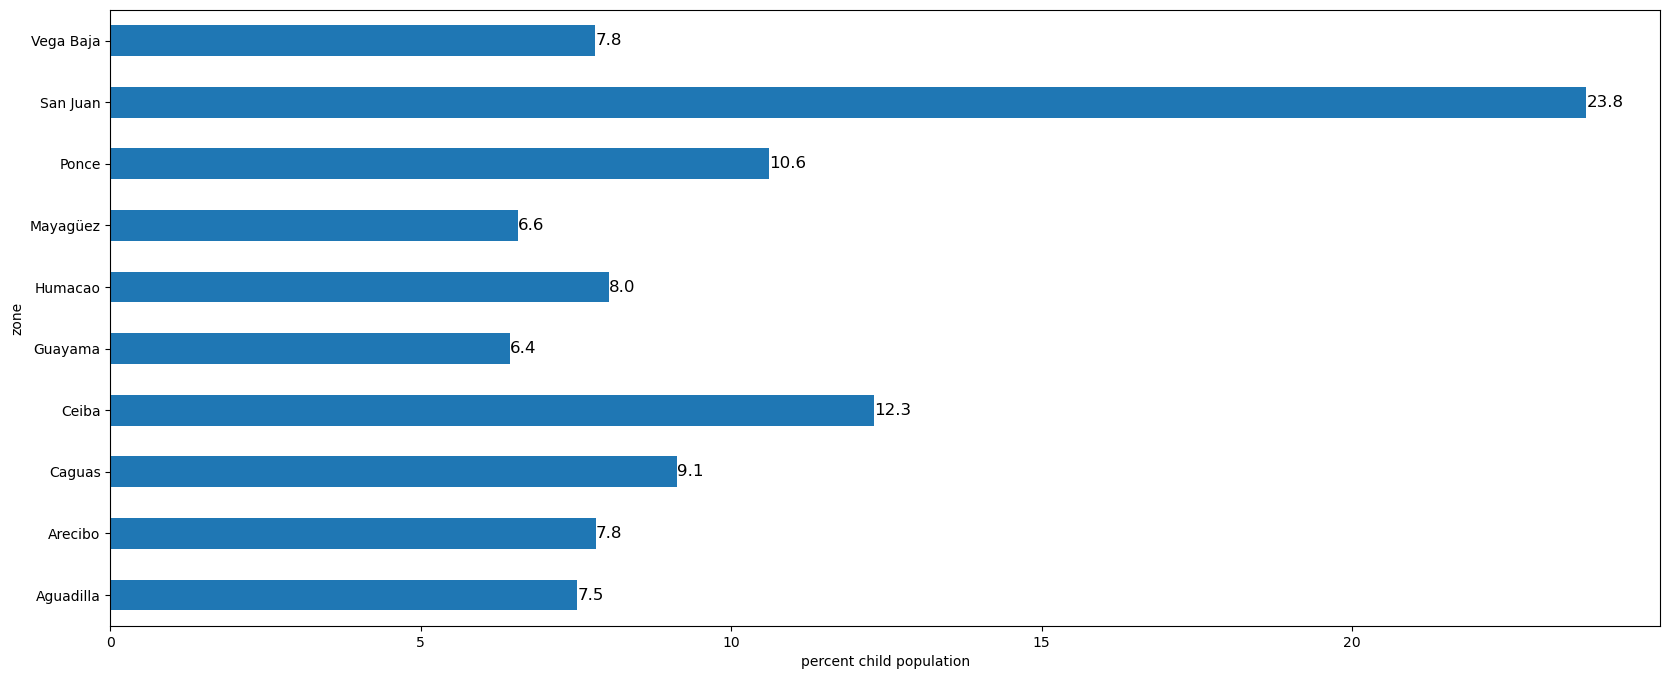

In [41]:
fig, ax = plt.subplots(figsize=(20,8))
df4['pct chld pop'].plot(kind='barh')
plt.xlabel('percent child population')
for i, v in enumerate(df4['pct chld pop']):
    ax.text(v, i, str(round(v,1)), color='black', fontsize=12, ha='left', va='center')


In [42]:
df4['pct chld pop'].sort_values(ascending=False)

zone
San Juan     23.774731
Ceiba        12.298314
Ponce        10.617017
Caguas        9.119889
Humacao       8.029608
Arecibo       7.814799
Vega Baja     7.811284
Aguadilla     7.522975
Mayagüez      6.569983
Guayama       6.441400
Name: pct chld pop, dtype: float64

### Get all the data we extracted from the API and aggregate it to NMEAD Operational Zone level. 

In [43]:
# create a dictionary holding a list of all the paths to the pickled data (dictionary values) organized by geographic level (dictionary keys)
paths_to_data_by_geo = {'barrios': ['../outputs/detailed_barrio.pkl', 
                                    '../outputs/profile_barrio.pkl', 
                                    '../outputs/subject_barrio.pkl'], 
                        'municipios': ['../outputs/detailed_municipio.pkl', 
                                       '../outputs/profile_municipio.pkl', 
                                       '../outputs/subject_municipio.pkl'], 
                        'tracts': ['../outputs/detailed_tract.pkl', 
                                   '../outputs/profile_tract.pkl', 
                                   '../outputs/subject_tract.pkl']}

# load the data we pulled from the Census API
def load_data(geo):
    
    path_to_pickle1, path_to_pickle2, path_to_pickle3 = paths_to_data_by_geo[geo]
        
    detailed_tables = pd.read_pickle(path_to_pickle1)
    data_profiles = pd.read_pickle(path_to_pickle2)
    subject_tables = pd.read_pickle(path_to_pickle3)
    
    return detailed_tables, data_profiles, subject_tables

Let's write a function that will sum the variables grouped by zone: 

In [44]:
def get_by_zone(geo):
    
    dt, dp, st = load_data(geo)

    dfs = [dt, dp, st]

    # extract municipio name and get zone
    for _Df in dfs:
        _Df = get_municipio_names_and_zones(_Df, geo)

    # create new dataframes: groupby('zone').sum()
    _by_zone = [] 
    for _Df in dfs: 
        _by_zone.append(_Df.groupby('zone').sum())
    
    return _by_zone

In [45]:
dt, dp, st = get_by_zone('municipios')

print(dt.shape, dp.shape, st.shape)

(10, 75) (10, 15) (10, 6)


Create one dataframe out of the three dataframes to have one dataframe with all info by zone. 

In [46]:
all_data_by_zone = dt.join(dp).join(st)

In [47]:
all_data_by_zone.shape

(10, 96)

Now, get the data at island-wide level, not grouped by zone. 

In [48]:
island_wide = [dt.sum(axis=0).transpose(), dp.sum(axis=0).transpose(), st.sum(axis=0).transpose()]
island_wide = pd.DataFrame(island_wide)
island_wide = island_wide.fillna(0)
island_wide = pd.DataFrame(island_wide.sum()).transpose()

In [49]:
island_wide.shape

(1, 96)

Inspect:

In [50]:
all_data_by_zone

total_pop  chld_pop  chld_pop_hh  pop_hh_under3  pop_hh_3to4  \
zone                                                                      
Aguadilla     254372     44933        44785           4558         4363   
Arecibo       262897     46676        46600           5297         4221   
Caguas        294611     54471        54348           5884         4827   
Ceiba         409870     73455        73381           7982         6837   
Guayama       204642     38473        38382           4181         3401   
Humacao       258011     47959        47874           5138         4407   
Mayagüez      229858     39241        39113           4250         3143   
Ponce         328908     63413        63048           7612         5698   
San Juan      824160    142001       141691          16690        13998   
Vega Baja     243945     46655        46641           5848         3979   

           pop_hh_5  pop_hh_6to8  pop_hh_9to11  pop_hh_12to14  pop_hh_15to17  \
zone                                                                           
Aguadilla      1896         7214          7987           9630           9137   
Arecibo        2402         6721          8079          10408           9472   
Caguas         2657         8237         10078          11527          11138   
Ceiba          3259        12507         13304          14333          15159   
Guayama        2041         6220          6917           7639           7983   
Humacao        2445         8245          8877           8810           9952   
Mayagüez       1782         6155          7316           8372           8095   
Ponce          2959        10124         11095          13375          12185   
San Juan       7399        23979         25251          25526          28848   
Vega Baja      2167         6895          9069           9334           9349   

           pop_under19  pop_under19_noHI  pov_under5_male  pov_5_male  \
zone                                                                    
Aguadilla        48256              1208             3052         750   
Arecibo          49917              1454             3238         851   
Caguas           58575              1546             3420         745   
Ceiba            78795              2613             4172         952   
Guayama          41533              1341             2604         865   
Humacao          51073              1660             3161         563   
Mayagüez         42551               868             2738         759   
Ponce            67264              1785             4532         929   
San Juan        153001              5619             8725        2160   
Vega Baja        50178              2742             3329         607   

           pov_6to11_male  pov_12to14_male  pov_15_male  pov_16to17_male  \
zone                                                                       
Aguadilla            4525             2715          890             1561   
Arecibo              4305             3039          945             1772   
Caguas               5543             3694         1035             2304   
Ceiba                6416             3105          914             2357   
Guayama              4373             2414          757             1516   
Humacao              4871             2015          885             1544   
Mayagüez             4116             2595          525             1765   
Ponce                7240             4080         1395             2711   
San Juan            12962             5809         2096             4988   
Vega Baja            4667             2879          594             1995   

           pov_under5_female  pov_5_female  pov_6to11_female  \
zone                                                           
Aguadilla               2895           456              4370   
Arecibo                 3079           621              4937   
Caguas                  2751           759              5444   
Ceiba                   3887           

In [51]:
island_wide

total_pop  chld_pop  chld_pop_hh  pop_hh_under3  pop_hh_3to4  pop_hh_5  \
0  3311274.0  597277.0     595863.0        67440.0      54874.0   29007.0   

   pop_hh_6to8  pop_hh_9to11  pop_hh_12to14  pop_hh_15to17  pop_under19  \
0      96297.0      107973.0       118954.0       121318.0     641143.0   

   pop_under19_noHI  pov_under5_male  pov_5_male  pov_6to11_male  \
0           20836.0          38971.0      9181.0         59018.0   

   pov_12to14_male  pov_15_male  pov_16to17_male  pov_under5_female  \
0          32345.0      10036.0          22513.0            36108.0   

   pov_5_female  pov_6to11_female  pov_12to14_female  pov_15_female  \
0        7979.0           58460.0            30413.0         9703.0   

   pov_16to17_female  no_pov_under5_male  no_pov_5_male  no_pov_6to11_male  \
0            19266.0             23431.0         5584.0            44041.0   

   no_pov_12to14_male  no_pov_15_male  no_pov_16to17_male  \
0             27090.0          9254.0             21077.0   

   no_pov_under5_female  no_pov_5_female  no_pov_6to11_female  \
0               23304.0           6091.0              41237.0   

   no_pov_12to14_female  no_pov_15_female  no_pov_16to17_female  \
0               28298.0            9424.0               20476.0   

   pop_under5_male_dis  pop_under5_male_no_dis  pop_5to17_male_dis  \
0                590.0                 62045.0             31139.0   

   pop_5to17_male_no_dis  pop_under5_female_dis  pop_under5_female_no_dis  \
0               210239.0                  867.0                   58812.0   

   pop_5to17_female_dis  pop_5to17_female_no_dis  pubschool_3to4_male  \
0               16950.0                 215937.0              12821.0   

   pubschool_5to9_male  pubschool_10to14_male  pubschool_15to17_male  \
0              58417.0                72614.0                44976.0   

   privschool_3to4_male  privschool_5to9_male  privschool_10to14_male  \
0                4349.0               20085.0                 23197.0   

   privschool_15to17_male  noschool_3to4_male  noschool_5to9_male  \
0                 14736.0             11728.0              2493.0   

   noschool_10to14_male  noschool_15to17_male  pubschool_3to4_female  \
0                1814.0                3572.0                10590.0   

   pubschool_5to9_female  pubschool_10to14_female  pubschool_15to17_female  \
0                55656.0                  71339.0                  43434.0   

   privschool_3to4_female  privschool_5to9_female  privschool_10to14_female  \
0                  4358.0                 20265.0                   22590.0   

   privschool_15to17_female  noschool_3to4_female  noschool_5to9_female  \
0                   13596.0               11113.0                2348.0   

   noschool_10to14_female  noschool_15to17_female  grndprntHH_noprnt  \
0                  1601.0                  2129.0            10103.0   

   chld_hh_no_internet  chld_hh_no_computer  chld_hh_cashasst  \
0              47680.0              49193.0          334581.0   

   total_own_children  own_children_oneprnt_under6  own_children_oneprnt_to17  \
0            570007.0                      98890.0                   255637.0   

   pop_16andover  pop_16andover_in_labor_force  pop_16andover_in_civilian_lf  \
0      2797936.0                     1238879.0                     1236011.0   

   pop_16andover_in_clf_employed  pop_16andover_in_clf_unemployed  \
0                      1055843.0                         180168.0   

   pop_16andover_in_armed_forces  pop_16andover_not_in_labor_force  \
0                         2868.0                         1559057.0   

   civilian_labor_force  unemployment_p  median_hh_income  housing_units  \
0             1236011.0          1165.6         1617061.0      1553791.0   

   occ_housing_units  occ_housing_no_vehicle  occ_housing_crowding_1  \
0          1196790.0                175572.0                 22688.0   

   occ_housing_crowding_2  housing_cost_burdened_inc1  \
0      

>These two dataframes contain all of the raw variable estimates, aggregated at NMEAD zone level (`all_data_by_zone`) or island-wide level (`island_zone`) 

Next, we define the 14 variables we used to compute the CVI. In fact, let's incorporate getting the data at zone level and island-wide level into a function as well. 

In [52]:
# define the variables
def define_variables(geo, island_wide=True):
    '''
    input: geo (string): 'barrios', 'municipios', or 'tracts'; 
           island_wide (boolean): set to True by default. If you want to define variables for NMEAD operational zones, set to False

    output: A pandas DataFrame with all the data pulled from the API plus the variables needed for calculating the CVI
    '''
    
    # LOAD THE DATA
    dt, dp, st = get_by_zone(geo)
    
    # CREATE A SINGLE DATAFRAME: name it `x`, as it's temporary
    # if computing the variables for the island as a whole:
    if island_wide == True:
        # compute for all PR
    
        x = [dt.sum(axis=0).transpose(), dp.sum(axis=0).transpose(), st.sum(axis=0).transpose()]
        x = pd.DataFrame(x)
        x = x.fillna(0)
        x = pd.DataFrame(x.sum()).transpose()
    
    # otherwise, if computing the variables grouped by NMEAD zone: 
    else: 
        x = dt.join(dp).join(st)
    
    # DEFINE THE VARIABLES BY THEME 
    
    # THEME 1: CHILDREN PERSONAL CHARACTERTISTICS
    
    #get child population rate 
    x['chld_pop_rate'] = x['chld_pop']/x['total_pop']

    # get total number of children for whom poverty status is determined
    poverty = [i for i in x.columns if 'pov_' in i]
    x['total_chld_with_pov_status'] = x[poverty].sum(axis=1)
    # get total number of children for whom status is determined that are living below the poverty line
    poverty_ = [i for i in poverty if i.startswith('pov')] 
    x['chld_below_pov'] = x[poverty_].sum(axis=1)
    # get child poverty rate
    x['chld_pov_rate'] = x['chld_below_pov']/x['total_chld_with_pov_status']
    
    #get fraction of children under 19 in the civilian noninstitutionalized population who do not have health insurance
    x['chld_no_HI_rate'] = x['pop_under19_noHI']/x['pop_under19']
    
    # get total number of children under 18 years old in the civilian noninstitutionalized population
    disabled = [i for i in x.columns if 'dis' in i]
    x['total_chld_civ_noninst'] = x[disabled].sum(axis=1)
    # get the number who are disabled
    disabled_ = [i for i in disabled if '_no' not in i]
    x['chld_dis'] = x[disabled_].sum(axis=1)
    # get child disability rate
    x['chld_dis_rate'] = x['chld_dis']/x['total_chld_civ_noninst']
    
    #get number of children ages 3 to 17 
    school = [i for i in x.columns if 'school' in i]
    x['pop_3to17'] = x[school].sum(axis=1)
    # get the number of those children who are not in school
    noschool = [i for i in school if "noschool" in i] 
    x['chld_no_school'] = x[noschool].sum(axis=1)
    # get the child no schooling rate 
    x['chld_no_school_rate'] = x['chld_no_school']/x['pop_3to17']
    
    # THEME 2: HOUSEHOLD WITH CHILDREN CHARACTERISTICS
    
    # get fraction of children living in households who live with grandparent households and no parents 
    x['grndprntHH_noprnt_rate'] = x['grndprntHH_noprnt']/x['chld_pop_hh']
    
    # get fraction of own children under 18 years living with one parent 
    x['under18_oneprnt'] = x['own_children_oneprnt_under6'] + x['own_children_oneprnt_to17']
    x['under18_oneprnt_rate'] = x['under18_oneprnt']/x['total_own_children']
    
    # get fraction of children living in households receiving SNAP, SSI, or cash assistance? 
    x['chld_hh_cashasst_rate'] = x['chld_hh_cashasst']/x['chld_pop_hh']
    
    # get fraction of children living in households with no internet 
    x['chld_hh_no_internet_rate'] = x['chld_hh_no_internet']/x['chld_pop_hh']
    
    # get fraction of children living in households with no computer 
    x['chld_hh_no_comp_rate'] = x['chld_hh_no_computer']/x['chld_pop_hh']
    
    # THEME 3: HOUSEHOLD COMPOSITION CHARACTERISTICS 
    
    # get the fraction of the population 16 years and over in the civilian labor force and unemployed
    x['unemployed_rate'] = x['pop_16andover_in_clf_unemployed']/x['pop_16andover']
    
    # get the fraction of occupied housing units with no vehicle 
    x['occ_housing_no_vehicle_rate'] = x['occ_housing_no_vehicle']/x['occ_housing_units']
    
    # get the fraction of occupied housing that is crowded (more than 1 person per room)
    # define the crowding variable 
    x['occ_housing_crowding'] = x['occ_housing_crowding_1'] + x['occ_housing_crowding_2']
    # get the fraction
    x['occ_housing_crowding_rate'] = x['occ_housing_crowding']/x['occ_housing_units']
    
    # get the fraction of occupied housing units with monthly housing costs as % of hh income >=30% 
    c = ['housing_cost_burdened_inc1', 'housing_cost_burdened_inc2', 'housing_cost_burdened_inc3', 
         'housing_cost_burdened_inc4', 'housing_cost_burdened_inc5']
    # define housing cost burden variable
    x['housing_cost_burden'] = x[c].sum(axis=1)
    # get fraction of occupied housing that is housing cost burdened
    x['housing_cost_burdened_rate'] = x['housing_cost_burden']/x['occ_housing']

    return x

In [53]:
all_by_zone = define_variables('municipios', island_wide=False)
all_by_zone

total_pop  chld_pop  chld_pop_hh  pop_hh_under3  pop_hh_3to4  \
zone                                                                      
Aguadilla     254372     44933        44785           4558         4363   
Arecibo       262897     46676        46600           5297         4221   
Caguas        294611     54471        54348           5884         4827   
Ceiba         409870     73455        73381           7982         6837   
Guayama       204642     38473        38382           4181         3401   
Humacao       258011     47959        47874           5138         4407   
Mayagüez      229858     39241        39113           4250         3143   
Ponce         328908     63413        63048           7612         5698   
San Juan      824160    142001       141691          16690        13998   
Vega Baja     243945     46655        46641           5848         3979   

           pop_hh_5  pop_hh_6to8  pop_hh_9to11  pop_hh_12to14  pop_hh_15to17  \
zone                                                                           
Aguadilla      1896         7214          7987           9630           9137   
Arecibo        2402         6721          8079          10408           9472   
Caguas         2657         8237         10078          11527          11138   
Ceiba          3259        12507         13304          14333          15159   
Guayama        2041         6220          6917           7639           7983   
Humacao        2445         8245          8877           8810           9952   
Mayagüez       1782         6155          7316           8372           8095   
Ponce          2959        10124         11095          13375          12185   
San Juan       7399        23979         25251          25526          28848   
Vega Baja      2167         6895          9069           9334           9349   

           pop_under19  pop_under19_noHI  pov_under5_male  pov_5_male  \
zone                                                                    
Aguadilla        48256              1208             3052         750   
Arecibo          49917              1454             3238         851   
Caguas           58575              1546             3420         745   
Ceiba            78795              2613             4172         952   
Guayama          41533              1341             2604         865   
Humacao          51073              1660             3161         563   
Mayagüez         42551               868             2738         759   
Ponce            67264              1785             4532         929   
San Juan        153001              5619             8725        2160   
Vega Baja        50178              2742             3329         607   

           pov_6to11_male  pov_12to14_male  pov_15_male  pov_16to17_male  \
zone                                                                       
Aguadilla            4525             2715          890             1561   
Arecibo              4305             3039          945             1772   
Caguas               5543             3694         1035             2304   
Ceiba                6416             3105          914             2357   
Guayama              4373             2414          757             1516   
Humacao              4871             2015          885             1544   
Mayagüez             4116             2595          525             1765   
Ponce                7240             4080         1395             2711   
San Juan            12962             5809         2096             4988   
Vega Baja            4667             2879          594             1995   

           pov_under5_female  pov_5_female  pov_6to11_female  \
zone                                                           
Aguadilla               2895           456              4370   
Arecibo                 3079           621              4937   
Caguas                  2751           759              5444   
Ceiba                   3887           

The resulting dataframe has too many columns. Reduce the size of the dataset by keeping only certain columns: 

In [54]:
def reduced_dataset(geo, island_wide=False):
    '''
    inputs:
    geo: 'barrios', 'municipios', 'tracts'
    

    output:
    Dataframe for the chosen geogrpahy with a reduced number of columns relevant for CVI computation.
    '''
    
    #bring all the data in and define the variables
    x = define_variables(geo, island_wide)
    
    # select columns of interest from the different output dataframes
    cols = ['total_pop', 'chld_pop', 'chld_pop_hh', 'chld_pop_rate', 'chld_pov_rate', 
            'chld_no_HI_rate', 'chld_dis_rate', 'chld_no_school_rate', 'grndprntHH_noprnt_rate', 
            'under18_oneprnt_rate', 'chld_hh_cashasst_rate', 'chld_hh_no_internet_rate', 
            'chld_hh_no_comp_rate'] 
    
    cols2 = ['unemployed_rate', 'occ_housing_no_vehicle_rate', 'occ_housing_crowding_rate']
    
    cols3 = ['housing_cost_burdened_rate'] 
    
    cols_to_keep = cols + cols2 + cols3
    
    # create dataframe with selected columns
    data = x[cols_to_keep]
    
    return data

In [55]:
all_by_zone = reduced_dataset('municipios', island_wide=False)
all_by_zone

total_pop  chld_pop  chld_pop_hh  chld_pop_rate  chld_pov_rate  \
zone                                                                        
Aguadilla     254372     44933        44785       0.176643       0.585176   
Arecibo       262897     46676        46600       0.177545       0.602315   
Caguas        294611     54471        54348       0.184891       0.572664   
Ceiba         409870     73455        73381       0.179215       0.492932   
Guayama       204642     38473        38382       0.188001       0.625036   
Humacao       258011     47959        47874       0.185880       0.527860   
Mayagüez      229858     39241        39113       0.170718       0.641003   
Ponce         328908     63413        63048       0.192799       0.647435   
San Juan      824160    142001       141691       0.172298       0.504507   
Vega Baja     243945     46655        46641       0.191252       0.583863   

           chld_no_HI_rate  chld_dis_rate  chld_no_school_rate  \
zone                                                             
Aguadilla         0.025033       0.051437             0.090353   
Arecibo           0.029128       0.052036             0.082409   
Caguas            0.026394       0.116448             0.077514   
Ceiba             0.033162       0.092816             0.053946   
Guayama           0.032288       0.141123             0.044063   
Humacao           0.032502       0.051722             0.077532   
Mayagüez          0.020399       0.097670             0.071961   
Ponce             0.026537       0.085429             0.060590   
San Juan          0.036725       0.077421             0.069801   
Vega Baja         0.054645       0.076174             0.072687   

           grndprntHH_noprnt_rate  under18_oneprnt_rate  \
zone                                                      
Aguadilla                0.011700              0.584162   
Arecibo                  0.012961              0.526420   
Caguas                   0.020314              0.646930   
Ceiba                    0.017103              0.633031   
Guayama                  0.016857              0.650157   
Humacao                  0.025108              0.618597   
Mayagüez                 0.023880              0.631491   
Ponce                    0.013339              0.669632   
San Juan                 0.015689              0.619051   
Vega Baja                0.016488              0.624814   

           chld_hh_cashasst_rate  chld_hh_no_internet_rate  \
zone                                                         
Aguadilla               0.581802                  0.115061   
Arecibo                 0.622318                  0.076330   
Caguas                  0.588338                  0.066111   
Ceiba                   0.514629                  0.026587   
Guayama                 0.581288                  0.027304   
Humacao                 0.542027                  0.027907   
Mayagüez                0.638611                  0.071639   
Ponce                   0.649156                  0.064966   
San Juan                0.484858                  0.113444   
Vega Baja               0.577175                  0.173024   

           chld_hh_no_comp_rate  unemployed_rate  occ_housing_no_vehicle_rate  \
zone                                                                            
Aguadilla              0.112426         0.053400                     0.129032   
Arecibo                0.058047         0.058881                     0.127871   
Caguas                 0.060904         0.049479                     0.137220   
Ceiba                  0.027419         0.081510                     0.122306   
Guayama                0.139076         0.034018                     0.153886   
Humacao                0.030914         0.056032                     0.123192   
Mayagüez               0.171094         0.070880                     0.167137   
Ponce                  0.077766         0.068048                     0.154012   
San Juan               0.1114

Check that you get the same results using different geographies as a sanity check: 

In [56]:
reduced_dataset('tracts', island_wide=False) == reduced_dataset('barrios', island_wide=False)

total_pop  chld_pop  chld_pop_hh  chld_pop_rate  chld_pov_rate  \
zone                                                                        
Aguadilla       True      True         True           True           True   
Arecibo         True      True         True           True           True   
Caguas          True      True         True           True           True   
Ceiba           True      True         True           True           True   
Guayama         True      True         True           True           True   
Humacao         True      True         True           True           True   
Mayagüez        True      True         True           True           True   
Ponce           True      True         True           True           True   
San Juan        True      True         True           True           True   
Vega Baja       True      True         True           True           True   

           chld_no_HI_rate  chld_dis_rate  chld_no_school_rate  \
zone                                                             
Aguadilla             True           True                 True   
Arecibo               True           True                 True   
Caguas                True           True                 True   
Ceiba                 True           True                 True   
Guayama               True           True                 True   
Humacao               True           True                 True   
Mayagüez              True           True                 True   
Ponce                 True           True                 True   
San Juan              True           True                 True   
Vega Baja             True           True                 True   

           grndprntHH_noprnt_rate  under18_oneprnt_rate  \
zone                                                      
Aguadilla                    True                  True   
Arecibo                      True                  True   
Caguas                       True                  True   
Ceiba                        True                  True   
Guayama                      True                  True   
Humacao                      True                  True   
Mayagüez                     True                  True   
Ponce                        True                  True   
San Juan                     True                  True   
Vega Baja                    True                  True   

           chld_hh_cashasst_rate  chld_hh_no_internet_rate  \
zone                                                         
Aguadilla                   True                      True   
Arecibo                     True                      True   
Caguas                      True                      True   
Ceiba                       True                      True   
Guayama                     True                      True   
Humacao                     True                      True   
Mayagüez                    True                      True   
Ponce                       True                      True   
San Juan                    True                      True   
Vega Baja                   True                      True   

           chld_hh_no_comp_rate  unemployed_rate  occ_housing_no_vehicle_rate  \
zone                                                                            
Aguadilla                  True             True                         True   
Arecibo                    True             True                         True   
Caguas                     True             True                         True   
Ceiba                      True             True                         True   
Guayama                    True             True                         True   
Humacao                    True             True                         True   
Mayagüez                   True             True                         True   
Ponce                      True             True                         True   
San Juan                   Tr

In [57]:
reduced_dataset('municipios', island_wide=False) == reduced_dataset('barrios', island_wide=False)

total_pop  chld_pop  chld_pop_hh  chld_pop_rate  chld_pov_rate  \
zone                                                                        
Aguadilla       True      True         True           True           True   
Arecibo         True      True         True           True           True   
Caguas          True      True         True           True           True   
Ceiba           True      True         True           True           True   
Guayama         True      True         True           True           True   
Humacao         True      True         True           True           True   
Mayagüez        True      True         True           True           True   
Ponce           True      True         True           True           True   
San Juan        True      True         True           True           True   
Vega Baja       True      True         True           True           True   

           chld_no_HI_rate  chld_dis_rate  chld_no_school_rate  \
zone                                                             
Aguadilla             True           True                 True   
Arecibo               True           True                 True   
Caguas                True           True                 True   
Ceiba                 True           True                 True   
Guayama               True           True                 True   
Humacao               True           True                 True   
Mayagüez              True           True                 True   
Ponce                 True           True                 True   
San Juan              True           True                 True   
Vega Baja             True           True                 True   

           grndprntHH_noprnt_rate  under18_oneprnt_rate  \
zone                                                      
Aguadilla                    True                  True   
Arecibo                      True                  True   
Caguas                       True                  True   
Ceiba                        True                  True   
Guayama                      True                  True   
Humacao                      True                  True   
Mayagüez                     True                  True   
Ponce                        True                  True   
San Juan                     True                  True   
Vega Baja                    True                  True   

           chld_hh_cashasst_rate  chld_hh_no_internet_rate  \
zone                                                         
Aguadilla                   True                      True   
Arecibo                     True                      True   
Caguas                      True                      True   
Ceiba                       True                      True   
Guayama                     True                      True   
Humacao                     True                      True   
Mayagüez                    True                      True   
Ponce                       True                      True   
San Juan                    True                      True   
Vega Baja                   True                      True   

           chld_hh_no_comp_rate  unemployed_rate  occ_housing_no_vehicle_rate  \
zone                                                                            
Aguadilla                  True             True                         True   
Arecibo                    True             True                         True   
Caguas                     True             True                         True   
Ceiba                      True             True                         True   
Guayama                    True             True                         True   
Humacao                    True             True                         True   
Mayagüez                   True             True                         True   
Ponce                      True             True                         True   
San Juan                   Tr

What are the 14 variables' values for the island as a whole? 

In [58]:
#it's ok to overwrite the old dataframe, we're not using it 
island_wide = reduced_dataset('barrios', island_wide=True)
island_wide.transpose() 

0
total_pop                    3.311274e+06
chld_pop                     5.972770e+05
chld_pop_hh                  5.958630e+05
chld_pop_rate                1.803768e-01
chld_pov_rate                5.629412e-01
chld_no_HI_rate              3.249821e-02
chld_dis_rate                8.305019e-02
chld_no_school_rate          6.945365e-02
grndprntHH_noprnt_rate       1.695524e-02
under18_oneprnt_rate         6.219696e-01
chld_hh_cashasst_rate        5.615066e-01
chld_hh_no_internet_rate     8.001839e-02
chld_hh_no_comp_rate         8.255757e-02
unemployed_rate              6.439318e-02
occ_housing_no_vehicle_rate  1.467024e-01
occ_housing_crowding_rate    2.472196e-02
housing_cost_burdened_rate   2.364057e-01

- 18.0% of the total population of Puerto Rico is children
- 56.3% of children whose poverty status is determined live below the poverty line. 
- 3.2% of children do not have health insurance. 
- 8.3% of children have a disability. 
- 6.9% of children ages 3 to 17 years old are not enrolled in school. 
- 1.7% of children living in households live in grandparent households with no parent present. 
- 62.2% of children live in households with one parent. 
- 56.2% of children living in households live in households receiving some public assistance. 
- 8.0% of children living in households live in households with no internet. 
- 8.3% of children living in households live in households with no computer. 
- 6.4% of the population 16 years and older is unemployed. 
- 14.7% of occupied housing in Puerto Rico have access to no vehicle. 
- 2.5% of occupied housing has more than 1 person living per room (crowding). 
- 23.6% of households in Puerto Rico are housing cost burdened, meaning 30% or more of household monthly income is spent covering housing costs. 

### Descriptive statistics of some variables by CVI quartile

Define CVI quartiles

In [59]:
df2['CVI_quartile'] = pd.cut(df2['CVI'], bins=4, labels=['low', 'low-medium', 'medium-high', 'high'])

What is the mean value of all the fourteen variables for barrios in the different CVI quartiles? 

In [60]:
variables = ['chld_pop_pcnt','chld_pov_pcnt','chld_no_HI_pcnt', 
             'chld_dis_pcnt','chld_no_school_pcnt', 'grndprntHH_noprnt_pcnt', 
             'under18_oneprnt_pcnt', 'chld_hh_cashasst_pcnt', 'chld_hh_no_internet_pcnt',
             'chld_hh_no_comp_pcnt','unemployed_pcnt', 'occ_housing_no_vehicle_pcnt',
             'occ_housing_crowding_pcnt', 'housing_cost_burdened_pcnt'  ]

In [61]:
df2.groupby('CVI_quartile')[variables].describe()

chld_pop_pcnt                                            \
                     count       mean       std       min        25%   
CVI_quartile                                                           
low                  212.0  16.083234  9.211818  1.632302  10.325838   
low-medium           211.0  17.363595  6.884747  3.118908  13.505223   
medium-high          211.0  19.355580  6.464961  6.136364  15.612638   
high                 211.0  20.366576  5.268001  6.412214  17.510446   

                                              chld_pov_pcnt             \
                    50%        75%        max         count       mean   
CVI_quartile                                                             
low           15.356268  20.427124  75.555556         212.0  45.150193   
low-medium    17.084282  20.194074  65.217391         211.0  57.504225   
medium-high   18.215979  22.068875  41.721854         211.0  66.034899   
high          19.561926  22.752356  41.983471         211.0  73.859761   

                                                                            \
                    std        min        25%        50%        75%    max   
CVI_quartile                                                                 
low           30.669406   0.000000  23.370686  40.770195  65.389721  100.0   
low-medium    23.142778   0.000000  41.146636  53.853854  69.939759  100.0   
medium-high   20.978096   3.971119  51.089516  64.116576  81.319789  100.0   
high          15.734643  33.892740  64.253472  73.098751  85.568055  100.0   

             chld_no_HI_pcnt                                          \
                       count      mean       std  min  25%       50%   
CVI_quartile                                                           
low                    212.0  2.580064  9.896682  0.0  0.0  0.000000   
low-medium             211.0  3.297945  8.879597  0.0  0.0  0.000000   
medium-high            211.0  2.898483  8.461244  0.0  0.0  0.000000   
high                   211.0  3.854298  5.515299  0.0  0.0  1.936219   

                                   chld_dis_pcnt                             \
                   75%         max         count       mean        std  min   
CVI_quartile                                                                  
low           0.000000  100.000000         212.0   2.801359   9.022186  0.0   
low-medium    2.575704   74.137931         211.0   8.162880  13.316054  0.0   
medium-high   3.442665  100.000000         211.0   8.177132   8.179866  0.0   
high          5.394366   32.812500         211.0  10.911480  10.005481  0.0   

                                                        chld_no_school_pcnt  \
                   25%       50%        75%         max               count   
CVI_quartile                                                                  
low           0.000000  0.000000   0.000000  100.000000               212.0   
low-medium    0.000000  2.803738  12.516716  100.000000               211.0   
medium-high   0.000000  6.382979  12.672817   36.000000               211.0   
high          4.808401  8.877996  14.688240   62.068966               211.0   

                                                                      \
                  mean        std  min      25%       50%        75%   
CVI_quartile                                                           
low           4.137573  12.447172  0.0  0.00000  0.000000   0.021853   
low-medium    7.797641  13.674385  0.0  0.00000  2.638522  10.565202   
medium-high   7.971169  10.630088  0.0  0.00000  6.032483  11.302117   
high          9.915209   9.969550  0.0  3.96436  7.647059  13.255059   

                         grndprntHH_noprnt_pcnt                                \
                     max                  count      mean       std  min  25%   
CVI_quartile                                                                    
low           100.000000                  212.0  1.360056  9.913489  0.0  0.0   


In [62]:
df2.groupby('CVI_quartile')[variables].mean()

chld_pop_pcnt  chld_pov_pcnt  chld_no_HI_pcnt  chld_dis_pcnt  \
CVI_quartile                                                                 
low               16.083234      45.150193         2.580064       2.801359   
low-medium        17.363595      57.504225         3.297945       8.162880   
medium-high       19.355580      66.034899         2.898483       8.177132   
high              20.366576      73.859761         3.854298      10.911480   

              chld_no_school_pcnt  grndprntHH_noprnt_pcnt  \
CVI_quartile                                                
low                      4.137573                1.360056   
low-medium               7.797641                1.743460   
medium-high              7.971169                1.742872   
high                     9.915209                2.628290   

              under18_oneprnt_pcnt  chld_hh_cashasst_pcnt  \
CVI_quartile                                                
low                      46.112970              47.476245   
low-medium               56.015254              57.993628   
medium-high              67.654627              67.238539   
high                     74.055113              72.313335   

              chld_hh_no_internet_pcnt  chld_hh_no_comp_pcnt  unemployed_pcnt  \
CVI_quartile                                                                    
low                           5.927624              5.463021         4.276134   
low-medium                    7.471627             11.396222         5.453028   
medium-high                   9.927145             10.998859         7.025995   
high                         11.929018             12.913300         8.013940   

              occ_housing_no_vehicle_pcnt  occ_housing_crowding_pcnt  \
CVI_quartile                                                           
low                              9.775896                   1.564444   
low-medium                      12.527660                   2.864299   
medium-high                     13.980146                   3.253440   
high                            19.490195                   3.903041   

              housing_cost_burdened_pcnt  
CVI_quartile                              
low                            15.118689  
low-medium                     17.232579  
medium-high                    20.632245  
high                           23.915599

### Distribution of variables at barrio level 

How are the variables distributed at barrio level?

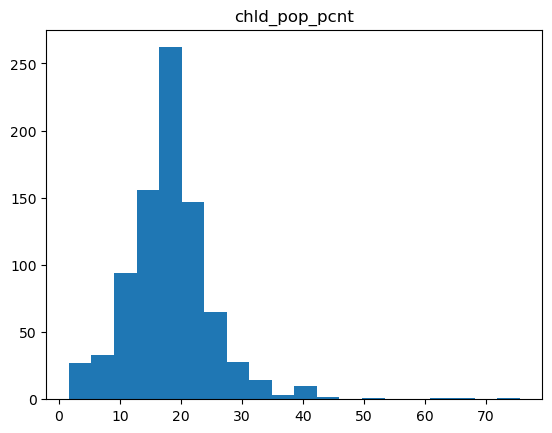

count    845.000000
mean      18.289632
std        7.287822
min        1.632302
25%       14.375206
50%       17.929503
75%       21.331316
max       75.555556
Name: chld_pop_pcnt, dtype: float64




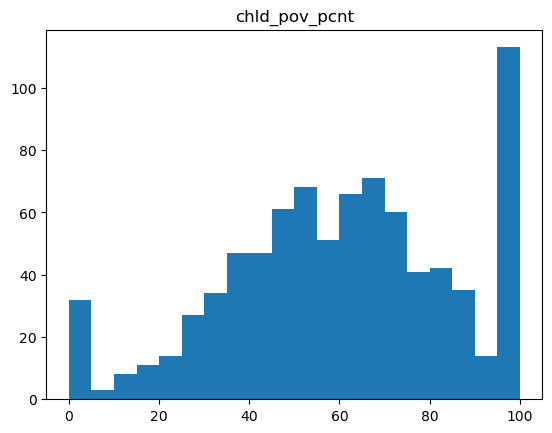

count    845.000000
mean      60.618942
std       25.557936
min        0.000000
25%       43.828017
50%       61.486486
75%       78.395062
max      100.000000
Name: chld_pov_pcnt, dtype: float64




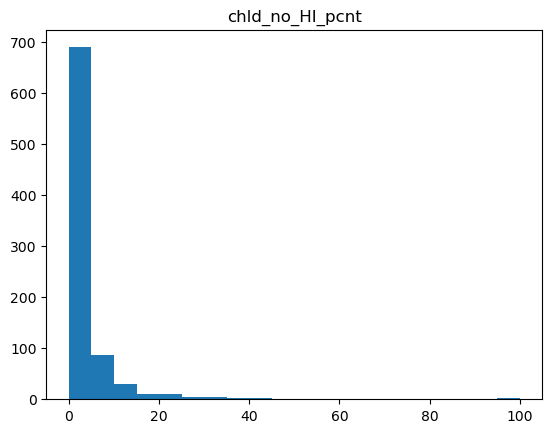

count    845.000000
mean       3.157014
std        8.349445
min        0.000000
25%        0.000000
50%        0.000000
75%        3.341709
max      100.000000
Name: chld_no_HI_pcnt, dtype: float64




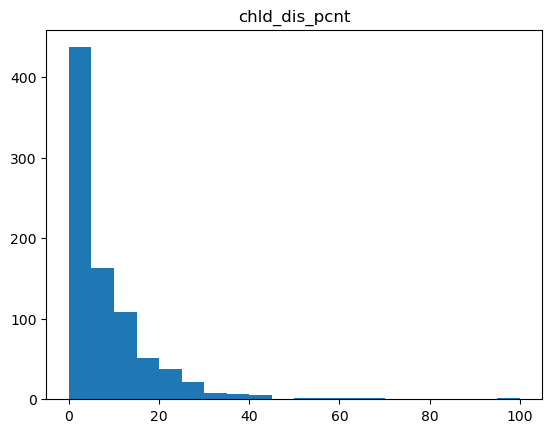

count    845.000000
mean       7.507636
std       10.710075
min        0.000000
25%        0.000000
50%        4.579731
75%       11.518325
max      100.000000
Name: chld_dis_pcnt, dtype: float64




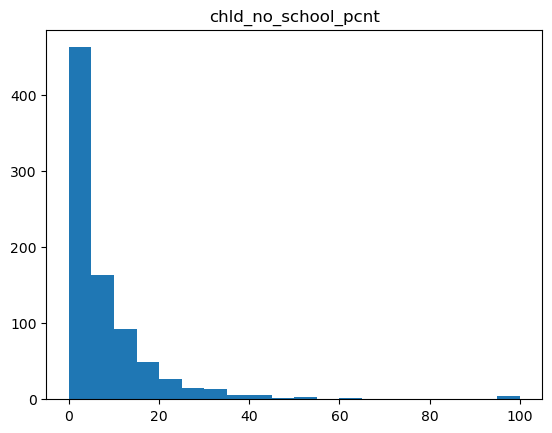

count    845.000000
mean       7.451472
std       11.936422
min        0.000000
25%        0.000000
50%        3.882476
75%       10.237660
max      100.000000
Name: chld_no_school_pcnt, dtype: float64




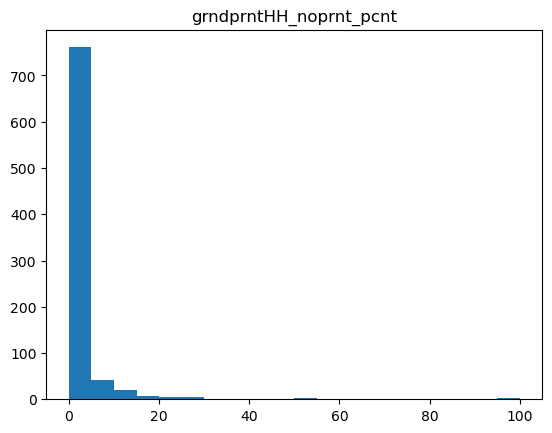

count    845.000000
mean       1.868068
std        6.869513
min        0.000000
25%        0.000000
50%        0.000000
75%        0.493171
max      100.000000
Name: grndprntHH_noprnt_pcnt, dtype: float64




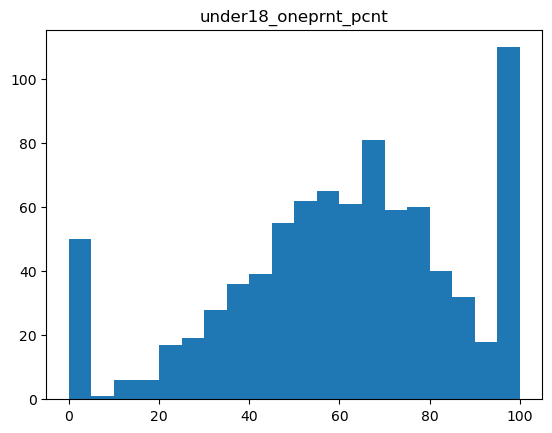

count    845.000000
mean      60.941921
std       26.257884
min        0.000000
25%       46.217331
50%       62.727273
75%       78.725962
max      100.000000
Name: under18_oneprnt_pcnt, dtype: float64




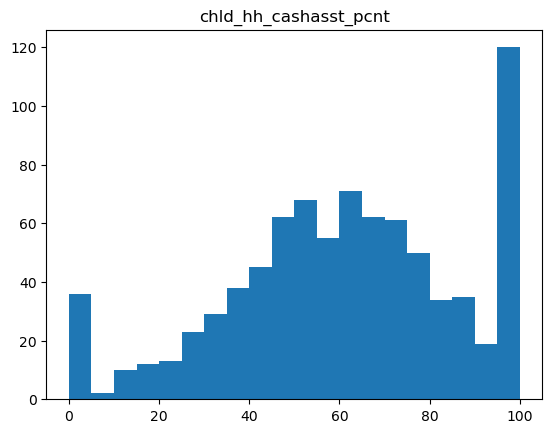

count    845.000000
mean      61.239130
std       26.019878
min        0.000000
25%       45.591594
50%       62.101669
75%       79.494382
max      100.000000
Name: chld_hh_cashasst_pcnt, dtype: float64




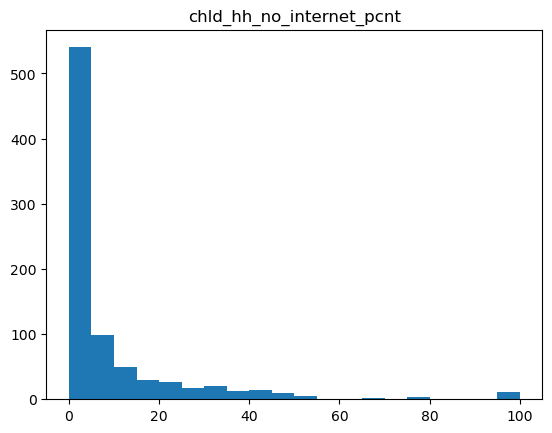

count    845.000000
mean       8.810438
std       17.105052
min        0.000000
25%        0.000000
50%        0.000000
75%        9.719626
max      100.000000
Name: chld_hh_no_internet_pcnt, dtype: float64




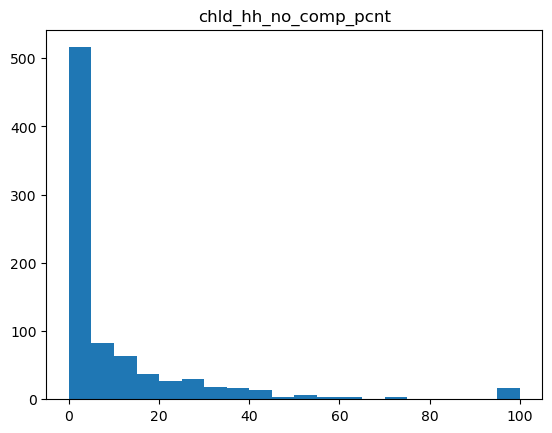

count    845.000000
mean      10.187253
std       18.654761
min        0.000000
25%        0.000000
50%        0.307915
75%       12.142039
max      100.000000
Name: chld_hh_no_comp_pcnt, dtype: float64




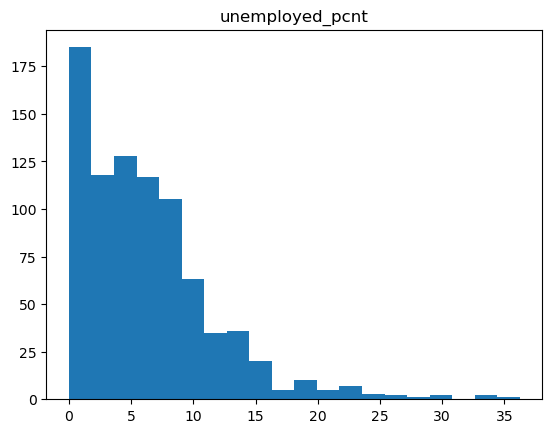

count    845.000000
mean       6.190007
std        5.454466
min        0.000000
25%        2.184814
50%        5.311138
75%        8.722741
max       36.244541
Name: unemployed_pcnt, dtype: float64




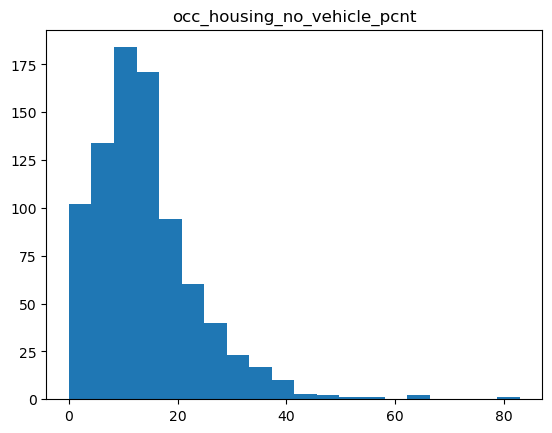

count    845.000000
mean      13.938543
std        9.743685
min        0.000000
25%        7.611798
50%       12.505833
75%       18.181818
max       82.978723
Name: occ_housing_no_vehicle_pcnt, dtype: float64




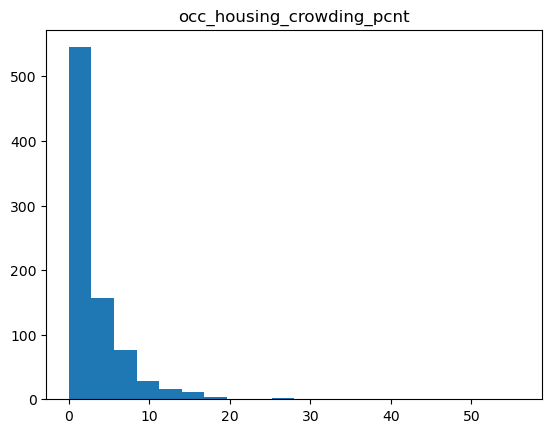

count    845.000000
mean       2.894730
std        4.650081
min        0.000000
25%        0.000000
50%        1.476264
75%        4.065041
max       56.000000
Name: occ_housing_crowding_pcnt, dtype: float64




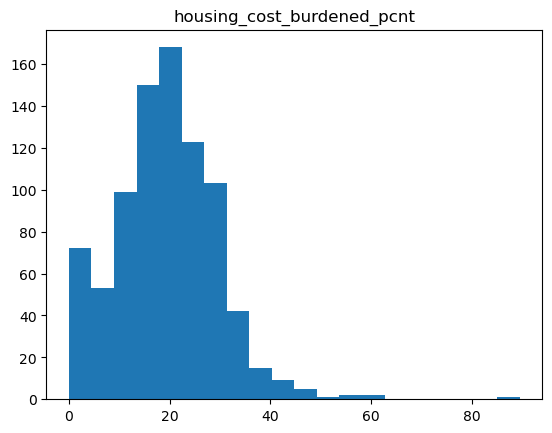

count    845.000000
mean      19.219919
std       10.308805
min        0.000000
25%       12.727273
50%       19.393939
75%       25.675676
max       89.552239
Name: housing_cost_burdened_pcnt, dtype: float64




In [63]:
for i, var in enumerate(variables):
    plt.figure(i+1)
    plt.title(var)
    plt.hist(df2[var], bins=20)
    plt.show()
    
    print(df2[var].describe())
    print('\n')

What municipios and NMEAD Operational Zones are the top 15 CVI barrios located in?

In [64]:
df2.sort_values(by='CVI', ascending=False).head(15)[['GEOID', 'NAME', 'CVI', 'zone', 'municipio']]

GEOID                                               NAME       CVI  \
0   7204519708  Comerío barrio-pueblo, Comerío Municipio, Puer...  1.000000   
1   7212757247    Oriente barrio, San Juan Municipio, Puerto Rico  0.998817   
2   7210556172  Naranjito barrio-pueblo, Naranjito Municipio, ...  0.997633   
3   7209752474  Mayagüez barrio-pueblo, Mayagüez Municipio, Pu...  0.996450   
4   7209150195  Manatí barrio-pueblo, Manatí Municipio, Puerto...  0.995266   
5   7212774017  Sabana Llana Norte barrio, San Juan Municipio,...  0.994083   
6   7212173587  Sabana Grande barrio-pueblo, Sabana Grande Mun...  0.992899   
7   7201758580  Palmas Altas barrio, Barceloneta Municipio, Pu...  0.991716   
8   7205328007  Fajardo barrio-pueblo, Fajardo Municipio, Puer...  0.990533   
9   7214570104  Río Abajo barrio, Vega Baja Municipio, Puerto ...  0.989349   
10  7211375565     San Antón barrio, Ponce Municipio, Puerto Rico  0.988166   
11  7212524352  Duey Bajo barrio, San Germán Municipio, Puerto...  0.986982   
12  7214516182     Ceiba barrio, Vega Baja Municipio, Puerto Rico  0.985799   
13  7207539015  Juana Díaz barrio-pueblo, Juana Díaz Municipio...  0.984615   
14  7201303411  Arecibo barrio-pueblo, Arecibo Municipio, Puer...  0.983432   

         zone      municipio  
0      Caguas        Comerío  
1    San Juan       San Juan  
2      Caguas      Naranjito  
3    Mayagüez       Mayagüez  
4   Vega Baja         Manatí  
5    San Juan       San Juan  
6    Mayagüez  Sabana Grande  
7     Arecibo    Barceloneta  
8       Ceiba        Fajardo  
9   Vega Baja      Vega Baja  
10      Ponce          Ponce  
11   Mayagüez     San Germán  
12  Vega Baja      Vega Baja  
13      Ponce     Juana Díaz  
14    Arecibo        Arecibo

### Get the number of barrios in each municipio and descriptive statistics of the CVIs of the barrios in the municipio

In [65]:
desc_stat_barrios_by_municipio = df2.groupby('municipio')['CVI'].describe().sort_values(by='count', ascending=False)
desc_stat_barrios_by_municipio

count      mean       std       min       25%       50%  \
municipio                                                                
Ponce           31.0  0.577897  0.320952  0.021302  0.384615  0.624852   
Utuado          22.0  0.454438  0.275849  0.010651  0.226036  0.514793   
San Sebastián   22.0  0.444137  0.324868  0.034320  0.174408  0.404142   
Añasco          20.0  0.325888  0.257156  0.002367  0.124852  0.252663   
Mayagüez        19.0  0.475927  0.332613  0.001183  0.205325  0.421302   
San Juan        18.0  0.724195  0.269903  0.190533  0.455030  0.807396   
Arecibo         18.0  0.526200  0.245325  0.093491  0.384024  0.527811   
San Germán      18.0  0.422814  0.286295  0.005917  0.188757  0.437870   
Aguada          18.0  0.375904  0.301338  0.015385  0.113905  0.283432   
Adjuntas        17.0  0.374939  0.355043  0.037870  0.082840  0.121893   
Cayey           17.0  0.313923  0.241288  0.029586  0.101775  0.252071   
Yauco           17.0  0.385868  0.287056  0.003550  0.215385  0.345562   
Aguadilla       16.0  0.476368  0.316094  0.024852  0.150740  0.515385   
Patillas        15.0  0.331203  0.265464  0.017751  0.108284  0.293491   
Orocovis        15.0  0.620276  0.246119  0.140828  0.469822  0.679290   
Guayanilla      14.0  0.470118  0.205756  0.028402  0.363905  0.518343   
Isabela         14.0  0.455452  0.258068  0.011834  0.271598  0.418935   
Vega Baja       13.0  0.682795  0.264722  0.320710  0.430769  0.790533   
Corozal         13.0  0.522713  0.253845  0.137278  0.315976  0.514793   
Humacao         13.0  0.374283  0.195919  0.018935  0.302367  0.420118   
Camuy           13.0  0.340373  0.178547  0.014201  0.254438  0.332544   
Carolina        13.0  0.578516  0.290427  0.049704  0.346746  0.724260   
Juana Díaz      13.0  0.551752  0.255366  0.181065  0.376331  0.525444   
Morovis         13.0  0.432408  0.285408  0.074556  0.216568  0.426036   
Cidra           13.0  0.485071  0.270661  0.022485  0.347929  0.531361   
Moca            12.0  0.531607  0.313488  0.020118  0.342751  0.584615   
Las Marías      12.0  0.335799  0.277765  0.079290  0.118343  0.224260   
Lares           12.0  0.595957  0.237760  0.133728  0.523077  0.642012   
Lajas           12.0  0.615878  0.257679  0.153846  0.507101  0.650296   
Bayamón         12.0  0.595069  0.255432  0.123077  0.518343  0.689349   
Peñuelas        11.0  0.582249  0.330968  0.060355  0.279290  0.707692   
Coamo           11.0  0.533190  0.260953  0.007101  0.401183  0.568047   
San Lorenzo     11.0  0.480796  0.281685  0.184615  0.274556  0.336095   
Caguas          11.0  0.599086  0.268094  0.182249  0.413609  0.626627   
Naguabo         10.0  0.498817  0.257763  0.188166  0.269231  0.512426   
Yabucoa         10.0  0.526627  0.281995  0.143195  0.295562  0.497041   
Rincón          10.0  0.245562  0.218550  0.041420  0.127811  0.167160   
Juncos          10.0  0.472012  0.317363  0.004734  0.230473  0.510059   
Hatillo         10.0  0.268757  0.159508  0.066272  0.152071  0.266864   
Gurabo          10.0  0.549290  0.235368  0.204734  0.363905  0.594083   
Guaynabo        10.0  0.397160  0.218211  0.092308  0.239645  0.402367   
Guayama         10.0  0.461183  0.259025  0.166864  0.267160  0.421893   
Jayuya           9.0  0.540960  0.291191  0.105325  0.304142  0.475740   
Maunabo          9.0  0.522682  0.281910  0.062722  0.340828  0.494675   
Aibonito         9.0  0.473636  0.342218  0.046154  0.164497  0.552663   
Aguas Buenas     9.0  0.472781  0.200629  0.192899  0.262722  0.457988   
Fajardo          9.0  0.459106  0.316549  0.033136  0.200000  0.447337   
Toa Alta         9.0  0.508876  0.298009  0.071006  0.351479  0.540828   
Río Grande       9.0  0.692834  0.177924  0.398817  0.607101  0.674556   
Ciales           9.0  0.557462  0.288854  0.102959  0.314201  0.582249   
Manatí           9.0  0.745299  0.290384  0.087574  0.675740  0.848521   
Cabo Rojo        9.0  0.613675  0.215068  0.355030  0.385799  0.680473   
Santa Isabel     8.

> Ponce is the municipio with the most number of barrios: it has 31. 

Create a histogram of the number of barrios per municipio

The median number of barrios per municipio is 10.0


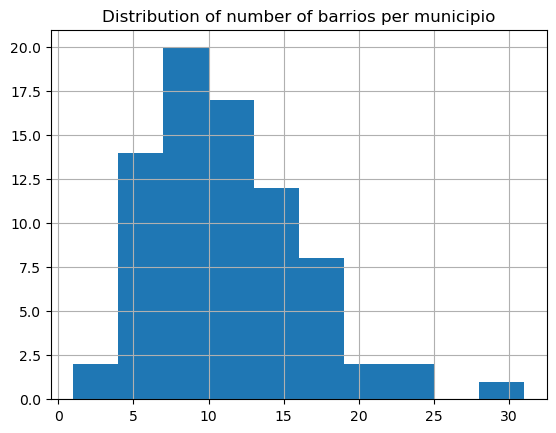

In [66]:
desc_stat_barrios_by_municipio['count'].hist()
plt.title('Distribution of number of barrios per municipio')

print('The median number of barrios per municipio is {}'.format(desc_stat_barrios_by_municipio['count'].median()))


In [67]:
desc_stat_barrios_by_municipio.sort_values(by='min')

count      mean       std       min       25%       50%  \
municipio                                                                
Mayagüez        19.0  0.475927  0.332613  0.001183  0.205325  0.421302   
Añasco          20.0  0.325888  0.257156  0.002367  0.124852  0.252663   
Yauco           17.0  0.385868  0.287056  0.003550  0.215385  0.345562   
Juncos          10.0  0.472012  0.317363  0.004734  0.230473  0.510059   
San Germán      18.0  0.422814  0.286295  0.005917  0.188757  0.437870   
Coamo           11.0  0.533190  0.260953  0.007101  0.401183  0.568047   
Maricao          6.0  0.506114  0.310701  0.009467  0.365976  0.578698   
Utuado          22.0  0.454438  0.275849  0.010651  0.226036  0.514793   
Isabela         14.0  0.455452  0.258068  0.011834  0.271598  0.418935   
Camuy           13.0  0.340373  0.178547  0.014201  0.254438  0.332544   
Aguada          18.0  0.375904  0.301338  0.015385  0.113905  0.283432   
Patillas        15.0  0.331203  0.265464  0.017751  0.108284  0.293491   
Humacao         13.0  0.374283  0.195919  0.018935  0.302367  0.420118   
Moca            12.0  0.531607  0.313488  0.020118  0.342751  0.584615   
Ponce           31.0  0.577897  0.320952  0.021302  0.384615  0.624852   
Cidra           13.0  0.485071  0.270661  0.022485  0.347929  0.531361   
Aguadilla       16.0  0.476368  0.316094  0.024852  0.150740  0.515385   
Guayanilla      14.0  0.470118  0.205756  0.028402  0.363905  0.518343   
Cayey           17.0  0.313923  0.241288  0.029586  0.101775  0.252071   
Culebra          4.0  0.195562  0.116328  0.030769  0.155030  0.236095   
Fajardo          9.0  0.459106  0.316549  0.033136  0.200000  0.447337   
San Sebastián   22.0  0.444137  0.324868  0.034320  0.174408  0.404142   
Sabana Grande    7.0  0.499070  0.316082  0.036686  0.344970  0.484024   
Adjuntas        17.0  0.374939  0.355043  0.037870  0.082840  0.121893   
Comerío          8.0  0.469675  0.411675  0.039053  0.115680  0.317751   
Rincón          10.0  0.245562  0.218550  0.041420  0.127811  0.167160   
Aibonito         9.0  0.473636  0.342218  0.046154  0.164497  0.552663   
Carolina        13.0  0.578516  0.290427  0.049704  0.346746  0.724260   
Vieques          5.0  0.473728  0.272505  0.052071  0.435503  0.527811   
Arroyo           6.0  0.661341  0.346726  0.056805  0.526036  0.802367   
Peñuelas        11.0  0.582249  0.330968  0.060355  0.279290  0.707692   
Maunabo          9.0  0.522682  0.281910  0.062722  0.340828  0.494675   
Hatillo         10.0  0.268757  0.159508  0.066272  0.152071  0.266864   
Ceiba            6.0  0.342604  0.237142  0.067456  0.171598  0.328994   
Toa Alta         9.0  0.508876  0.298009  0.071006  0.351479  0.540828   
Las Piedras      8.0  0.353254  0.268739  0.073373  0.180178  0.298225   
Morovis         13.0  0.432408  0.285408  0.074556  0.216568  0.426036   
Trujillo Alto    8.0  0.348447  0.265140  0.078107  0.112130  0.324260   
Las Marías      12.0  0.335799  0.277765  0.079290  0.118343  0.224260   
Manatí           9.0  0.745299  0.290384  0.087574  0.675740  0.848521   
Guaynabo        10.0  0.397160  0.218211  0.092308  0.239645  0.402367   
Arecibo         18.0  0.526200  0.245325  0.093491  0.384024  0.527811   
Ciales           9.0  0.557462  0.288854  0.102959  0.314201  0.582249   
Jayuya           9.0  0.540960  0.291191  0.105325  0.304142  0.475740   
Bayamón         12.0  0.595069  0.255432  0.123077  0.518343  0.689349   
Barceloneta      4.0  0.628698  0.376809  0.124260  0.464201  0.699408   
Lares           12.0  0.595957  0.237760  0.133728  0.523077  0.642012   
Corozal         13.0  0.522713  0.253845  0.137278  0.315976  0.514793   
Vega Alta        8.0  0.613979  0.249743  0.138462  0.502367  0.634320   
Orocovis        15.0  0.620276  0.246119  0.140828  0.469822  0.679290   
Yabucoa         10.0  0.526627  0.281995  0.143195  0.295562  0.497041   
Lajas           12.0  0.615878  0.257679  0.153846  0.507101  0.650296   
Quebradillas     8.

In [68]:
desc_stat_barrios_by_municipio.sort_values(by='max')

count      mean       std       min       25%       50%  \
municipio                                                                
Culebra          4.0  0.195562  0.116328  0.030769  0.155030  0.236095   
Camuy           13.0  0.340373  0.178547  0.014201  0.254438  0.332544   
Hatillo         10.0  0.268757  0.159508  0.066272  0.152071  0.266864   
Ceiba            6.0  0.342604  0.237142  0.067456  0.171598  0.328994   
Aguas Buenas     9.0  0.472781  0.200629  0.192899  0.262722  0.457988   
Guayanilla      14.0  0.470118  0.205756  0.028402  0.363905  0.518343   
Humacao         13.0  0.374283  0.195919  0.018935  0.302367  0.420118   
Rincón          10.0  0.245562  0.218550  0.041420  0.127811  0.167160   
Hormigueros      5.0  0.667219  0.210753  0.294675  0.711243  0.753846   
Vieques          5.0  0.473728  0.272505  0.052071  0.435503  0.527811   
Trujillo Alto    8.0  0.348447  0.265140  0.078107  0.112130  0.324260   
Quebradillas     8.0  0.323373  0.221115  0.163314  0.186391  0.247929   
Cayey           17.0  0.313923  0.241288  0.029586  0.101775  0.252071   
Dorado           5.0  0.618698  0.241305  0.210651  0.621302  0.682840   
Guaynabo        10.0  0.397160  0.218211  0.092308  0.239645  0.402367   
Florida          1.0  0.846154       NaN  0.846154  0.846154  0.846154   
Añasco          20.0  0.325888  0.257156  0.002367  0.124852  0.252663   
Canóvanas        6.0  0.700394  0.144653  0.528994  0.575444  0.711834   
Bayamón         12.0  0.595069  0.255432  0.123077  0.518343  0.689349   
Isabela         14.0  0.455452  0.258068  0.011834  0.271598  0.418935   
Cidra           13.0  0.485071  0.270661  0.022485  0.347929  0.531361   
Gurabo          10.0  0.549290  0.235368  0.204734  0.363905  0.594083   
Lares           12.0  0.595957  0.237760  0.133728  0.523077  0.642012   
Las Marías      12.0  0.335799  0.277765  0.079290  0.118343  0.224260   
Corozal         13.0  0.522713  0.253845  0.137278  0.315976  0.514793   
Moca            12.0  0.531607  0.313488  0.020118  0.342751  0.584615   
Aguadilla       16.0  0.476368  0.316094  0.024852  0.150740  0.515385   
Toa Baja         5.0  0.723077  0.155361  0.480473  0.697041  0.738462   
Maricao          6.0  0.506114  0.310701  0.009467  0.365976  0.578698   
Las Piedras      8.0  0.353254  0.268739  0.073373  0.180178  0.298225   
Jayuya           9.0  0.540960  0.291191  0.105325  0.304142  0.475740   
Aguada          18.0  0.375904  0.301338  0.015385  0.113905  0.283432   
Loíza            5.0  0.687101  0.238147  0.384615  0.481657  0.795266   
Peñuelas        11.0  0.582249  0.330968  0.060355  0.279290  0.707692   
Lajas           12.0  0.615878  0.257679  0.153846  0.507101  0.650296   
Vega Alta        8.0  0.613979  0.249743  0.138462  0.502367  0.634320   
Juncos          10.0  0.472012  0.317363  0.004734  0.230473  0.510059   
Toa Alta         9.0  0.508876  0.298009  0.071006  0.351479  0.540828   
Yauco           17.0  0.385868  0.287056  0.003550  0.215385  0.345562   
Luquillo         6.0  0.597436  0.305063  0.197633  0.353846  0.649704   
Carolina        13.0  0.578516  0.290427  0.049704  0.346746  0.724260   
Utuado          22.0  0.454438  0.275849  0.010651  0.226036  0.514793   
Cabo Rojo        9.0  0.613675  0.215068  0.355030  0.385799  0.680473   
Naguabo         10.0  0.498817  0.257763  0.188166  0.269231  0.512426   
Patillas        15.0  0.331203  0.265464  0.017751  0.108284  0.293491   
Yabucoa         10.0  0.526627  0.281995  0.143195  0.295562  0.497041   
Adjuntas        17.0  0.374939  0.355043  0.037870  0.082840  0.121893   
Cataño           2.0  0.942604  0.004184  0.939645  0.941124  0.942604   
Guayama         10.0  0.461183  0.259025  0.166864  0.267160  0.421893   
Salinas          5.0  0.719763  0.238392  0.389349  0.550296  0.852071   
Aibonito         9.0  0.473636  0.342218  0.046154  0.164497  0.552663   
Ciales           9.0  0.557462  0.288854  0.102959  0.314201  0.582249   
Santa Isabel     8.

How many municipios have barrios in all CVI quartiles? 

In [69]:
m = (desc_stat_barrios_by_municipio['min'] < 0.25) & (desc_stat_barrios_by_municipio['max'] > 0.75)
desc_stat_barrios_by_municipio[m].shape[0]

59

### Comerío

Comerío is the municipio that contains the barrio with highest CVI. 

What is the CVI of all the barrios in this municipio?

In [70]:
df2[df2['municipio']=='Comerío'][['barrio', 'CVI']]

barrio       CVI
0    Comerío barrio-pueblo  1.000000
56          Palomas barrio  0.933728
69          Naranjo barrio  0.918343
531      Doña Elena barrio  0.371598
622    Vega Redonda barrio  0.263905
747         Cedrito barrio  0.115976
748       Río Hondo barrio  0.114793
812           Piñas barrio  0.039053

Characteristics of barrio-pueblo in Comerio:

In [71]:
df2.head(1).transpose()

0
GEOID                                                                   7204519708
NAME                             Comerío barrio-pueblo, Comerío Municipio, Puer...
total_pop                                                                     4186
chld_pop                                                                      1049
chld_pop_hh                                                                   1049
chld_pop_pcnt                                                            25.059723
chld_pov_pcnt                                                            93.803622
chld_no_HI_pcnt                                                           1.989619
chld_dis_pcnt                                                             2.192564
chld_no_school_pcnt                                                      14.084507
grndprntHH_noprnt_pcnt                                                    4.861773
under18_oneprnt_pcnt                                                     98.096192
chld_hh_cashasst_pcnt                                                    78.455672
chld_hh_no_internet_pcnt                                                  23.92755
chld_hh_no_comp_pcnt                                                      33.36511
unemployed_pcnt                                                          11.895098
occ_housing_no_vehicle_pcnt                                              35.087719
occ_housing_crowding_pcnt                                                 3.921569
housing_cost_burdened_pcnt                                               16.924665
rank_pct_chld_pop                                                         0.886391
rank_pct_chld_pov                                                         0.862722
rank_pct_chld_no_HI                                                       0.689941
rank_pct_chld_dis                                                         0.435503
rank_pct_chld_no_school                                                    0.83787
rank_pct_grndprntHH_noprnt                                                0.898225
rank_pct_under18_oneprnt                                                   0.87574
rank_pct_chld_hh_cashasst                                                 0.738462
rank_pct_chld_hh_no_internet                                              0.876923
rank_pct_chld_hh_no_comp                                                  0.910059
rank_pct_unemployed                                                       0.876923
rank_pct_occ_housing_no_vehicle                                           0.970414
rank_pct_occ_housing_crowding                                             0.743195
rank_pct_housing_cost_burdened                                            0.394083
sum_of_all_rank_percentiles                                               10.99645
CVI                                                                            1.0
sum_rp_thm1                                                               3.712426
index_thm1                                                                0.969231
sum_rp_thm2                                                               4.299408
index_thm2                                                                0.998817
sum_rp_thm3                                                               2.984615
index_thm3                                                                0.934911
flags                                                                          2.0
barrio                                                       Comerío barrio-pueblo
municipio                                                                  Comerío
zone                                                                        Caguas
CVI_quartile                                                                  high

Characteristics of the municipio of Comerio:

In [72]:
df = get_data('municipios')
m = df['NAME'].str.contains('Comer')
df[m].transpose()

10
GEOID                                                     72045
NAME                             Comerío Municipio, Puerto Rico
total_pop                                                 18990
chld_pop                                                   3591
chld_pop_hh                                                3591
chld_pop_pcnt                                         18.909953
chld_pov_pcnt                                         73.322194
chld_no_HI_pcnt                                        1.424361
chld_dis_pcnt                                          7.212476
chld_no_school_pcnt                                    4.191617
grndprntHH_noprnt_pcnt                                 4.455583
under18_oneprnt_pcnt                                  72.864322
chld_hh_cashasst_pcnt                                 69.896965
chld_hh_no_internet_pcnt                              17.460317
chld_hh_no_comp_pcnt                                  16.318574
unemployed_pcnt                                        6.276495
occ_housing_no_vehicle_pcnt                           19.624573
occ_housing_crowding_pcnt                              1.839211
housing_cost_burdened_pcnt                            16.477057
rank_pct_chld_pop                                      0.692308
rank_pct_chld_pov                                      0.923077
rank_pct_chld_no_HI                                    0.217949
rank_pct_chld_dis                                      0.474359
rank_pct_chld_no_school                                0.153846
rank_pct_grndprntHH_noprnt                             0.948718
rank_pct_under18_oneprnt                               0.884615
rank_pct_chld_hh_cashasst                              0.846154
rank_pct_chld_hh_no_internet                           0.884615
rank_pct_chld_hh_no_comp                               0.846154
rank_pct_unemployed                                         0.5
rank_pct_occ_housing_no_vehicle                        0.948718
rank_pct_occ_housing_crowding                          0.333333
rank_pct_housing_cost_burdened                         0.166667
sum_of_all_rank_percentiles                            8.820513
CVI                                                    0.871795
sum_rp_thm1                                            2.461538
index_thm1                                             0.435897
sum_rp_thm2                                            4.410256
index_thm2                                                  1.0
sum_rp_thm3                                            1.948718
index_thm3                                             0.474359
flags                                                         3

# Descriptive Statistics: All variables @ municipio, barrio, and census tract level

In [73]:
df_municipios = get_data('municipios')
df_barrios = get_data('barrios')
df_census_tracts = get_data('tracts')

df_municipios[variables].describe().transpose()

count       mean        std        min  \
chld_pop_pcnt                 78.0  18.424271   1.252251  15.471194   
chld_pov_pcnt                 78.0  58.868405  11.342041  21.658986   
chld_no_HI_pcnt               78.0   2.843998   1.904220   0.000000   
chld_dis_pcnt                 78.0   7.861638   4.276738   0.000000   
chld_no_school_pcnt           78.0   6.975149   2.800375   1.286550   
grndprntHH_noprnt_pcnt        78.0   1.844959   1.439637   0.000000   
under18_oneprnt_pcnt          78.0  62.412394   8.448047  34.632231   
chld_hh_cashasst_pcnt         78.0  59.292212  10.519249  33.285646   
chld_hh_no_internet_pcnt      78.0   8.085328   8.852545   0.000000   
chld_hh_no_comp_pcnt          78.0   8.134276   8.433499   0.488827   
unemployed_pcnt               78.0   6.266376   3.013245   0.857331   
occ_housing_no_vehicle_pcnt   78.0  13.899206   3.313362   6.946271   
occ_housing_crowding_pcnt     78.0   2.768450   1.630282   0.506928   
housing_cost_burdened_pcnt    78.0  20.840098   4.527030  12.182203   

                                   25%        50%        75%        max  
chld_pop_pcnt                17.585970  18.291787  19.167441  21.241212  
chld_pov_pcnt                52.850871  59.064559  66.302130  85.998715  
chld_no_HI_pcnt               1.597330   2.709558   3.949429  10.836263  
chld_dis_pcnt                 4.904114   7.567241  10.225523  19.837079  
chld_no_school_pcnt           5.206360   6.672220   8.756132  15.579985  
grndprntHH_noprnt_pcnt        0.929957   1.443161   2.462793   8.202194  
under18_oneprnt_pcnt         57.596168  61.861775  68.337380  82.697548  
chld_hh_cashasst_pcnt        53.462718  60.498246  66.536278  80.352552  
chld_hh_no_internet_pcnt      2.416033   4.970355  10.644746  39.514049  
chld_hh_no_comp_pcnt          2.558215   5.019556   9.656518  37.256909  
unemployed_pcnt               3.454744   6.301343   8.291955  12.807206  
occ_housing_no_vehicle_pcnt  11.671724  13.444041  15.662310  24.529601  
occ_housing_crowding_pcnt     1.621046   2.585179   3.312197   9.406953  
housing_cost_burdened_pcnt   18.683586  20.267779  23.111086  32.867830

In [74]:
df_barrios[variables].describe().transpose()

count       mean        std       min        25%  \
chld_pop_pcnt                845.0  18.289632   7.287822  1.632302  14.375206   
chld_pov_pcnt                845.0  60.618942  25.557936  0.000000  43.828017   
chld_no_HI_pcnt              845.0   3.157014   8.349445  0.000000   0.000000   
chld_dis_pcnt                845.0   7.507636  10.710075  0.000000   0.000000   
chld_no_school_pcnt          845.0   7.451472  11.936422  0.000000   0.000000   
grndprntHH_noprnt_pcnt       845.0   1.868068   6.869513  0.000000   0.000000   
under18_oneprnt_pcnt         845.0  60.941921  26.257884  0.000000  46.217331   
chld_hh_cashasst_pcnt        845.0  61.239130  26.019878  0.000000  45.591594   
chld_hh_no_internet_pcnt     845.0   8.810438  17.105052  0.000000   0.000000   
chld_hh_no_comp_pcnt         845.0  10.187253  18.654761  0.000000   0.000000   
unemployed_pcnt              845.0   6.190007   5.454466  0.000000   2.184814   
occ_housing_no_vehicle_pcnt  845.0  13.938543   9.743685  0.000000   7.611798   
occ_housing_crowding_pcnt    845.0   2.894730   4.650081  0.000000   0.000000   
housing_cost_burdened_pcnt   845.0  19.219919  10.308805  0.000000  12.727273   

                                   50%        75%         max  
chld_pop_pcnt                17.929503  21.331316   75.555556  
chld_pov_pcnt                61.486486  78.395062  100.000000  
chld_no_HI_pcnt               0.000000   3.341709  100.000000  
chld_dis_pcnt                 4.579731  11.518325  100.000000  
chld_no_school_pcnt           3.882476  10.237660  100.000000  
grndprntHH_noprnt_pcnt        0.000000   0.493171  100.000000  
under18_oneprnt_pcnt         62.727273  78.725962  100.000000  
chld_hh_cashasst_pcnt        62.101669  79.494382  100.000000  
chld_hh_no_internet_pcnt      0.000000   9.719626  100.000000  
chld_hh_no_comp_pcnt          0.307915  12.142039  100.000000  
unemployed_pcnt               5.311138   8.722741   36.244541  
occ_housing_no_vehicle_pcnt  12.505833  18.181818   82.978723  
occ_housing_crowding_pcnt     1.476264   4.065041   56.000000  
housing_cost_burdened_pcnt   19.393939  25.675676   89.552239

In [75]:
df_census_tracts[variables].describe().transpose()

count       mean        std       min        25%  \
chld_pop_pcnt                919.0  17.697095   5.531254  0.655431  13.970530   
chld_pov_pcnt                919.0  56.061209  22.622659  0.000000  42.054351   
chld_no_HI_pcnt              919.0   3.552111   5.696755  0.000000   0.000000   
chld_dis_pcnt                919.0   8.370893   7.622020  0.000000   2.560979   
chld_no_school_pcnt          919.0   7.083303   7.650845  0.000000   0.000000   
grndprntHH_noprnt_pcnt       919.0   1.918907   4.039235  0.000000   0.000000   
under18_oneprnt_pcnt         919.0  62.822873  19.464832  0.000000  50.762895   
chld_hh_cashasst_pcnt        919.0  55.289016  23.600248  0.000000  39.925643   
chld_hh_no_internet_pcnt     919.0   7.654775  11.360450  0.000000   0.000000   
chld_hh_no_comp_pcnt         919.0   8.693331  12.888505  0.000000   0.000000   
unemployed_pcnt              919.0   6.832719   4.505000  0.000000   3.468349   
occ_housing_no_vehicle_pcnt  919.0  15.929691  10.913894  0.000000   8.820335   
occ_housing_crowding_pcnt    919.0   2.489899   2.417026  0.000000   0.595409   
housing_cost_burdened_pcnt   919.0  23.852698   8.750710  3.078677  17.610951   

                                   50%        75%         max  
chld_pop_pcnt                17.601459  20.706488   45.108696  
chld_pov_pcnt                58.268934  72.174654  100.000000  
chld_no_HI_pcnt               0.918635   5.010546   49.097473  
chld_dis_pcnt                 7.021132  12.438768   49.044586  
chld_no_school_pcnt           5.438931  10.620608  100.000000  
grndprntHH_noprnt_pcnt        0.000000   2.284985   30.319149  
under18_oneprnt_pcnt         63.626609  76.221001  100.000000  
chld_hh_cashasst_pcnt        58.151476  72.503749  100.000000  
chld_hh_no_internet_pcnt      3.249097  10.638544   70.125786  
chld_hh_no_comp_pcnt          3.260870  12.213571   73.243243  
unemployed_pcnt               6.059719   9.041366   29.112795  
occ_housing_no_vehicle_pcnt  13.414634  19.731650   74.004425  
occ_housing_crowding_pcnt     1.866252   3.775438   16.136919  
housing_cost_burdened_pcnt   23.330991  29.445944   56.081808

# Maps: Visualizations

We can create choropleths at municipio, barrio, or census tract level for Puerto Rico for any of the variables comprising the CVI. 

To showcase this capacity, let's work with barrio data (county subdivisions). 

In [76]:
barrios_variables = df2[['GEOID']+variables]
barrios_variables.shape

(845, 15)

To get ready to plot we need to get the shapefile of Puerto Rican county subdivisions. 

In [77]:
# Access shapefile of Puerto Rico barrios (county subdivisions)
pr_barrios = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/COUSUB/tl_2021_72_cousub.zip")

In [78]:
# Reproject shapefile to UTM Zone 20N
# https://spatialreference.org/ref/epsg/wgs-84-utm-zone-20n/
pr_barrios = pr_barrios.to_crs(epsg =32620) 

# Print GeoDataFrame of shapefile
print(pr_barrios.head(2))
print('Shape: ', pr_barrios.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(pr_barrios.crs))

  STATEFP COUNTYFP COUSUBFP  COUSUBNS       GEOID     NAME        NAMELSAD  \
0      72      095    11108  02415222  7209511108  Calzada  Calzada barrio   
1      72      095    45766  02415587  7209545766    Lizas    Lizas barrio   

  LSAD CLASSFP  MTFCC CNECTAFP NECTAFP NCTADVFP FUNCSTAT    ALAND   AWATER  \
0   20      Z1  G4040     None    None     None        N  8380177  1395062   
1   20      Z1  G4040     None    None     None        N  5944736        0   

      INTPTLAT      INTPTLON  \
0  +17.9895862  -065.9196839   
1  +18.0216472  -065.9388368   

                                            geometry  
0  POLYGON ((188858.899 1991771.025, 188950.215 1...  
1  POLYGON ((187067.057 1994568.572, 187099.944 1...  
Shape:  (939, 19)

The shapefile projection is: epsg:32620


In [79]:
# change the data type of the GEOID column to be a string object 
barrios_variables['GEOID'] = barrios_variables['GEOID'].apply(lambda x: str(x))

In [80]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
pr_merge = pr_barrios.merge(barrios_variables.reset_index(), on = "GEOID")

# Show result
print(pr_merge.head(2))
print('Shape: ', pr_merge.shape)

  STATEFP COUNTYFP COUSUBFP  COUSUBNS       GEOID     NAME        NAMELSAD  \
0      72      095    11108  02415222  7209511108  Calzada  Calzada barrio   
1      72      095    45766  02415587  7209545766    Lizas    Lizas barrio   

  LSAD CLASSFP  MTFCC CNECTAFP NECTAFP NCTADVFP FUNCSTAT    ALAND   AWATER  \
0   20      Z1  G4040     None    None     None        N  8380177  1395062   
1   20      Z1  G4040     None    None     None        N  5944736        0   

      INTPTLAT      INTPTLON  \
0  +17.9895862  -065.9196839   
1  +18.0216472  -065.9388368   

                                            geometry  index  chld_pop_pcnt  \
0  POLYGON ((188858.899 1991771.025, 188950.215 1...    792      17.633929   
1  POLYGON ((187067.057 1994568.572, 187099.944 1...    422      17.724551   

   chld_pov_pcnt  chld_no_HI_pcnt  chld_dis_pcnt  chld_no_school_pcnt  \
0      38.607595              0.0            0.0                  0.0   
1      70.270270              0.0            0.0    

In [81]:
pr_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 845 entries, 0 to 844
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   STATEFP                      845 non-null    object  
 1   COUNTYFP                     845 non-null    object  
 2   COUSUBFP                     845 non-null    object  
 3   COUSUBNS                     845 non-null    object  
 4   GEOID                        845 non-null    object  
 5   NAME                         845 non-null    object  
 6   NAMELSAD                     845 non-null    object  
 7   LSAD                         845 non-null    object  
 8   CLASSFP                      845 non-null    object  
 9   MTFCC                        845 non-null    object  
 10  CNECTAFP                     0 non-null      object  
 11  NECTAFP                      0 non-null      object  
 12  NCTADVFP                     0 non-null      object  
 1

### Create maps! 

Child population rate

Text(0.5, 1.0, 'Child Population Rate (%) in Puerto Rico')

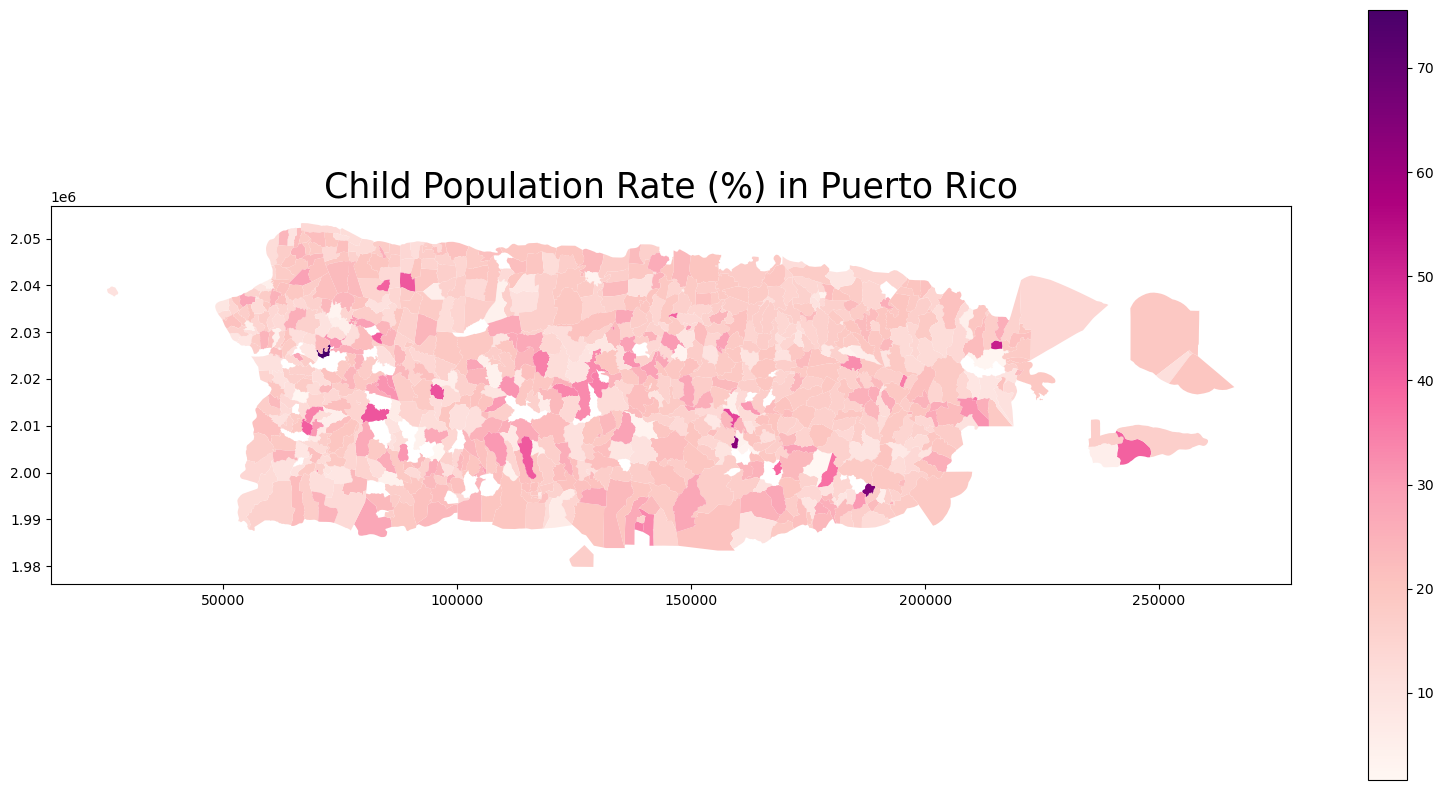

In [82]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "chld_pop_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Child Population Rate (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

Child Poverty Rate

Text(0.5, 1.0, 'Child Poverty Rate (%) in Puerto Rico')

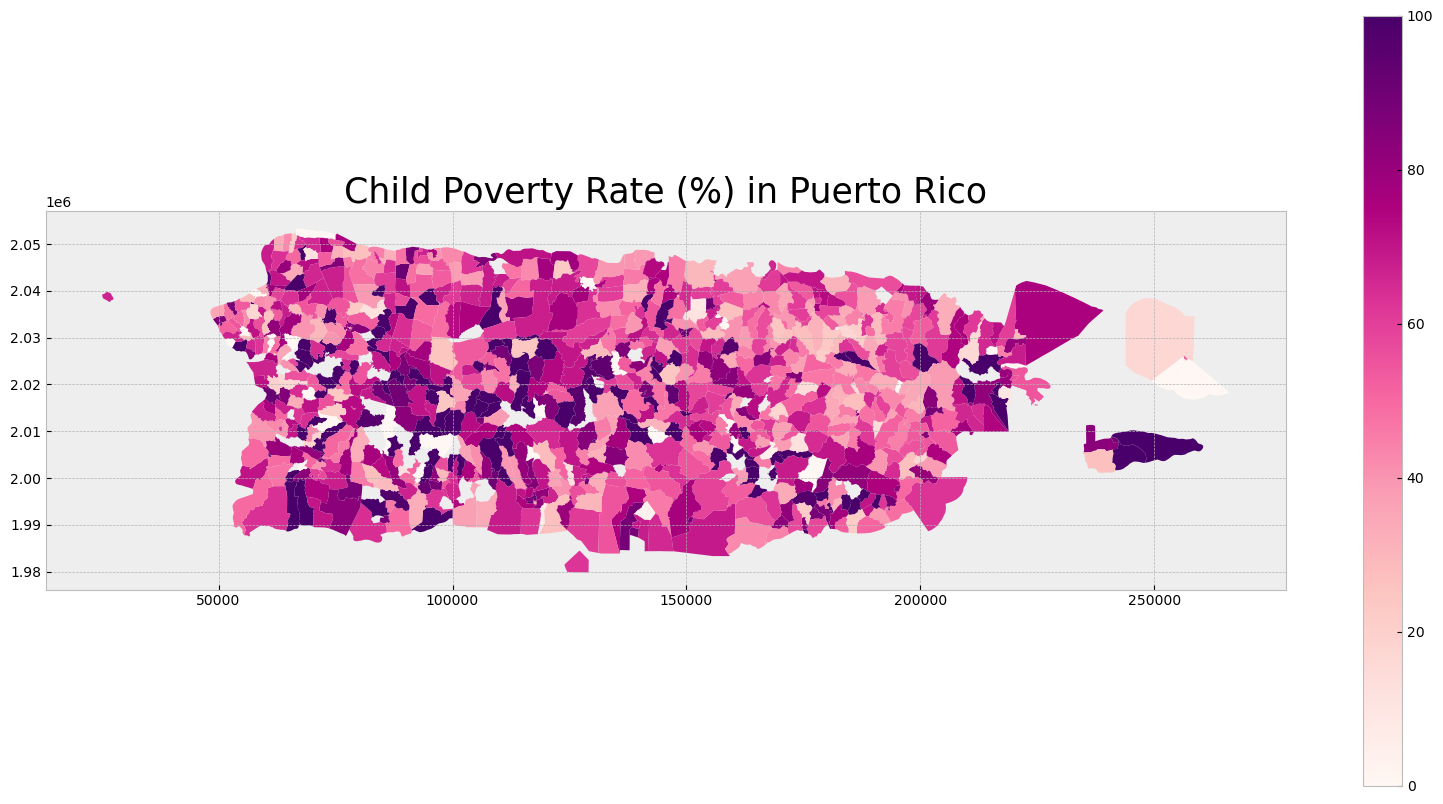

In [83]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "chld_pov_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Child Poverty Rate (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

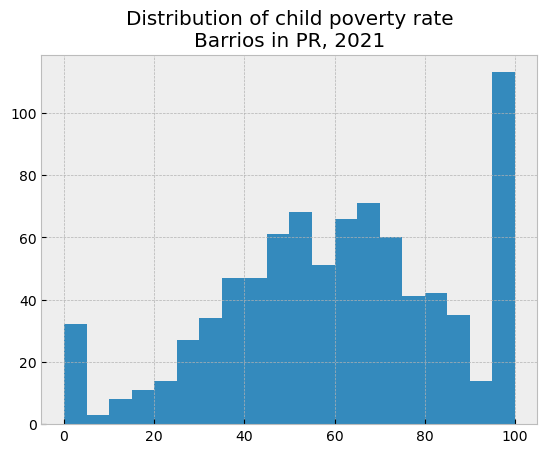

In [84]:
pr_merge['chld_pov_pcnt'].hist(bins=20)
plt.title('Distribution of child poverty rate\nBarrios in PR, 2021');

Let's normalize this variable and create the map with the normalized variable. 

In [85]:
# normalize the child poverty rate variable 
mean_chld_pov = pr_merge['chld_pov_pcnt'].mean()
std_chld_pov = pr_merge['chld_pov_pcnt'].std()

pr_merge['norm_chld_pov_pcnt'] = (pr_merge['chld_pov_pcnt'] - mean_chld_pov)/std_chld_pov

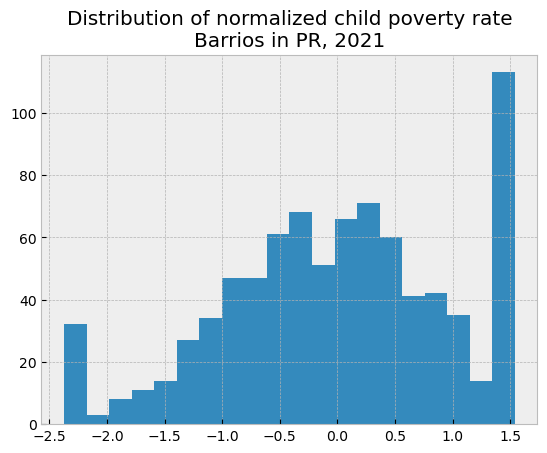

In [86]:
pr_merge['norm_chld_pov_pcnt'].hist(bins=20)
plt.title('Distribution of normalized child poverty rate\nBarrios in PR, 2021');

In [87]:
pr_merge['norm_chld_pov_pcnt'].describe()

count    8.450000e+02
mean     7.567911e-17
std      1.000000e+00
min     -2.371825e+00
25%     -6.569750e-01
50%      3.394425e-02
75%      6.955225e-01
max      1.540854e+00
Name: norm_chld_pov_pcnt, dtype: float64

Text(0.5, 1.0, 'Normalized Child Poverty Rate (%) in Puerto Rico')

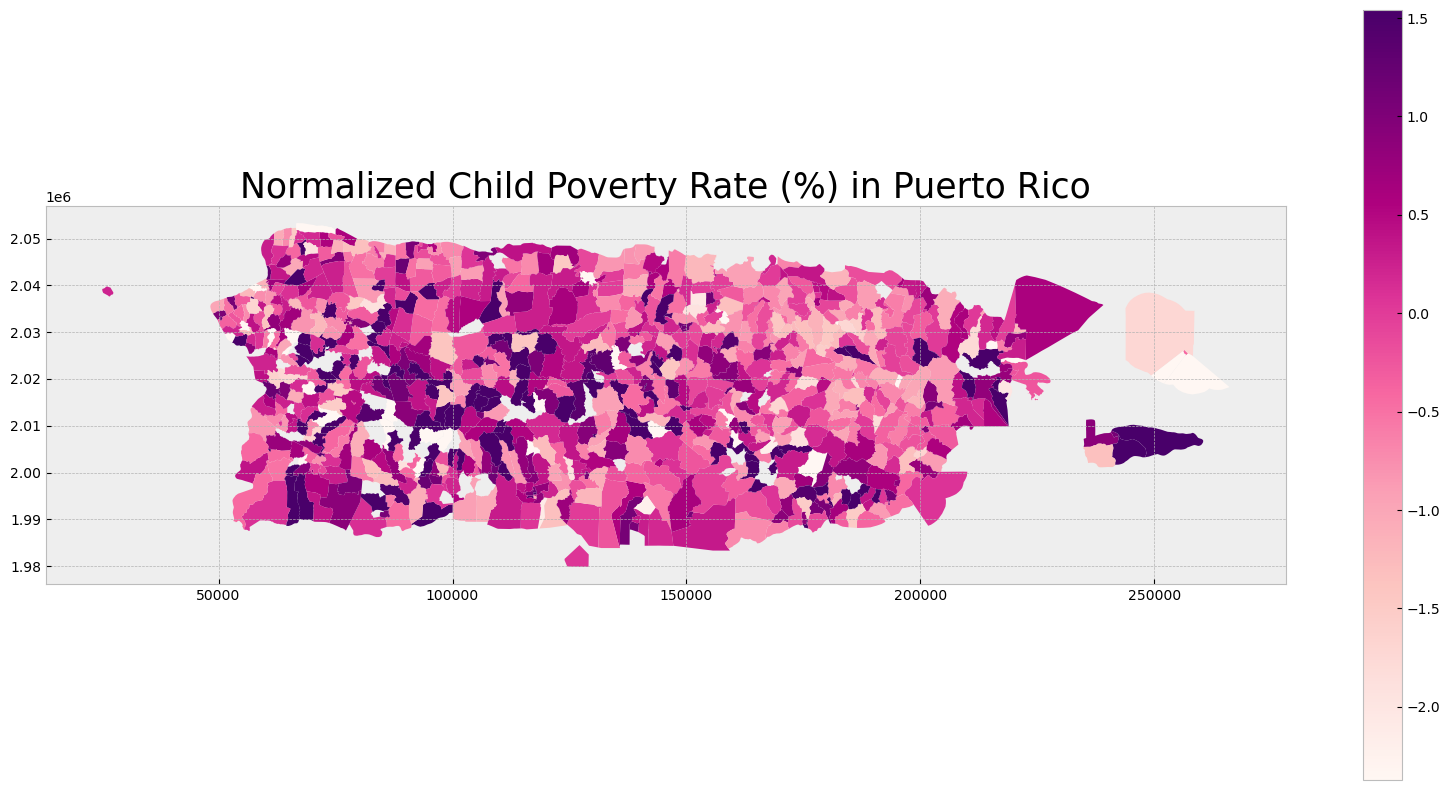

In [88]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "norm_chld_pov_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Normalized Child Poverty Rate (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

Housing cost burdened households

Text(0.5, 1.0, 'Housing Cost Burdened Households (%) in Puerto Rico')

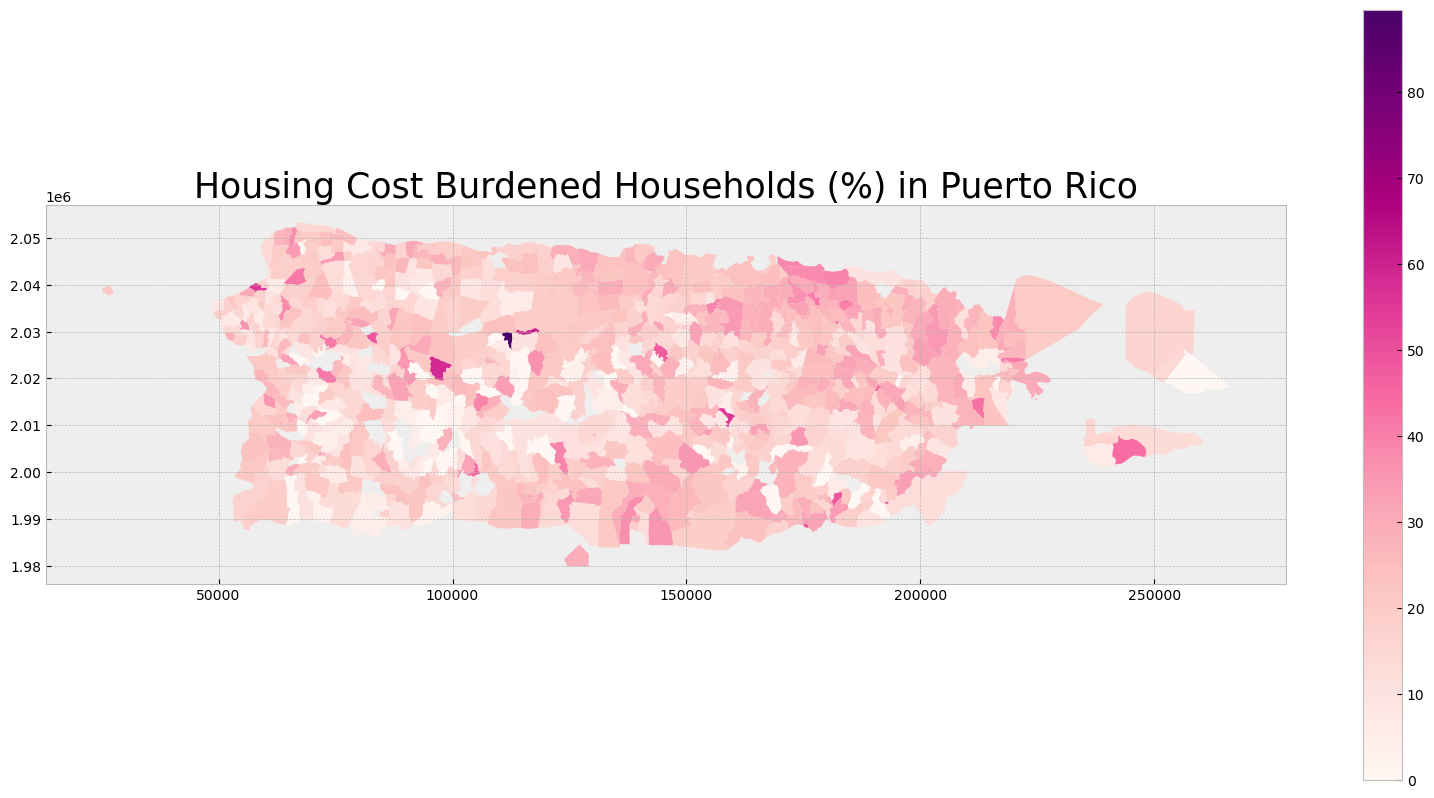

In [89]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "housing_cost_burdened_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Housing Cost Burdened Households (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [90]:
pr_merge['housing_cost_burdened_pcnt'].describe()

count    845.000000
mean      19.219919
std       10.308805
min        0.000000
25%       12.727273
50%       19.393939
75%       25.675676
max       89.552239
Name: housing_cost_burdened_pcnt, dtype: float64

<AxesSubplot: >

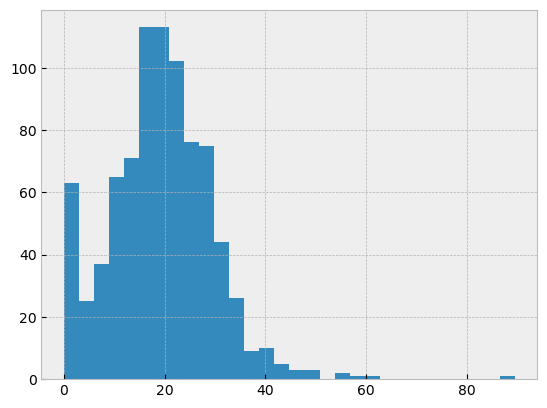

In [91]:
pr_merge['housing_cost_burdened_pcnt'].hist(bins=30)

Children without health insurance

Text(0.5, 1.0, 'Children under 19 years old with no health insurance (%) in Puerto Rico')

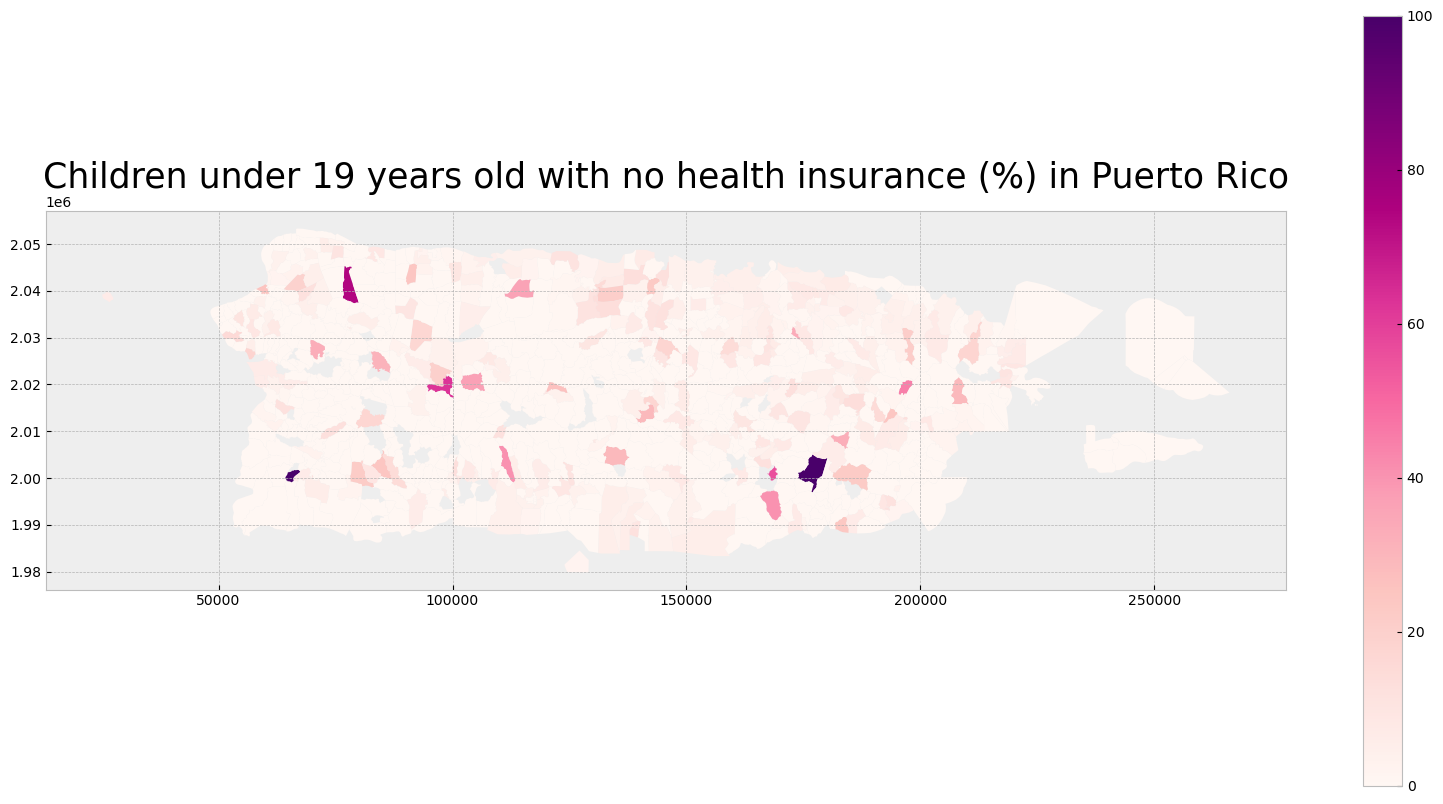

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "chld_no_HI_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Children under 19 years old with no health insurance (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [93]:
pr_merge['chld_no_HI_pcnt'].describe()

count    845.000000
mean       3.157014
std        8.349445
min        0.000000
25%        0.000000
50%        0.000000
75%        3.341709
max      100.000000
Name: chld_no_HI_pcnt, dtype: float64

<AxesSubplot: >

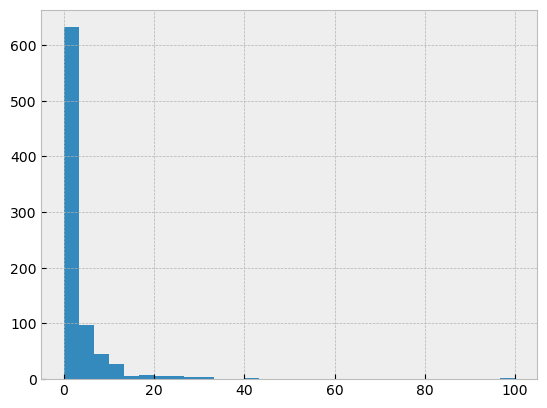

In [94]:
pr_merge['chld_no_HI_pcnt'].hist(bins=30)

In [95]:
variables

['chld_pop_pcnt',
 'chld_pov_pcnt',
 'chld_no_HI_pcnt',
 'chld_dis_pcnt',
 'chld_no_school_pcnt',
 'grndprntHH_noprnt_pcnt',
 'under18_oneprnt_pcnt',
 'chld_hh_cashasst_pcnt',
 'chld_hh_no_internet_pcnt',
 'chld_hh_no_comp_pcnt',
 'unemployed_pcnt',
 'occ_housing_no_vehicle_pcnt',
 'occ_housing_crowding_pcnt',
 'housing_cost_burdened_pcnt']

Overcrowding

Text(0.5, 1.0, 'Occupied housing with more than 1 person per room (%) in Puerto Rico')

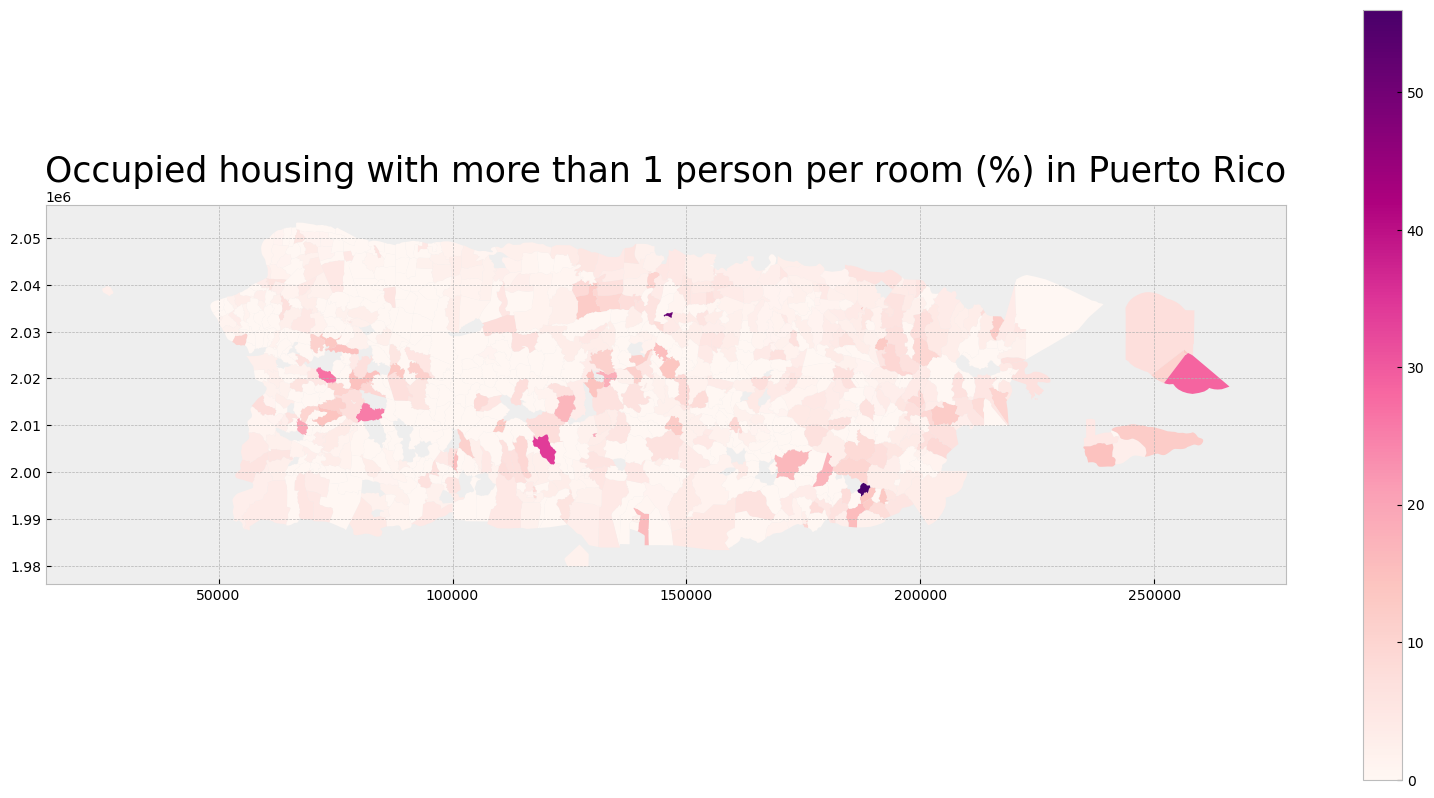

In [96]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "occ_housing_crowding_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Occupied housing with more than 1 person per room (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [97]:
pr_merge['occ_housing_crowding_pcnt'].describe()

count    845.000000
mean       2.894730
std        4.650081
min        0.000000
25%        0.000000
50%        1.476264
75%        4.065041
max       56.000000
Name: occ_housing_crowding_pcnt, dtype: float64

<AxesSubplot: >

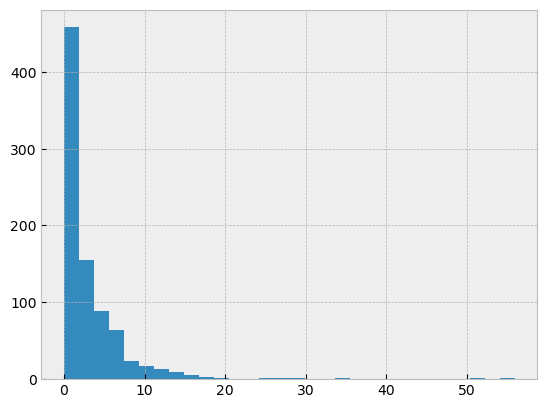

In [98]:
pr_merge['occ_housing_crowding_pcnt'].hist(bins=30)

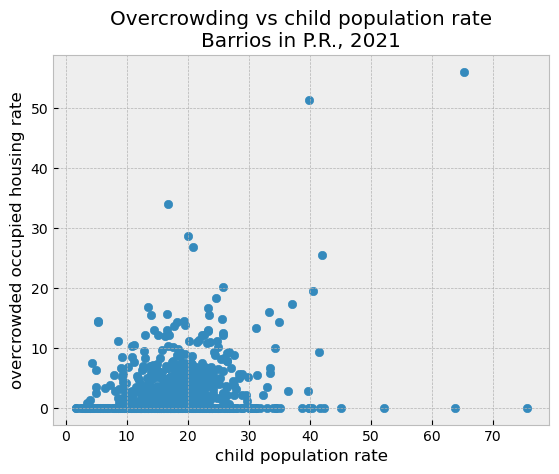

In [99]:
plt.scatter(pr_merge['chld_pop_pcnt'], pr_merge['occ_housing_crowding_pcnt'])
plt.xlabel('child population rate')
plt.ylabel('overcrowded occupied housing rate')
plt.title('Overcrowding vs child population rate\nBarrios in P.R., 2021');

Occupied housing with no vehicle available

Text(0.5, 1.0, 'Occupied housing with no vehicle available (%) in Puerto Rico')

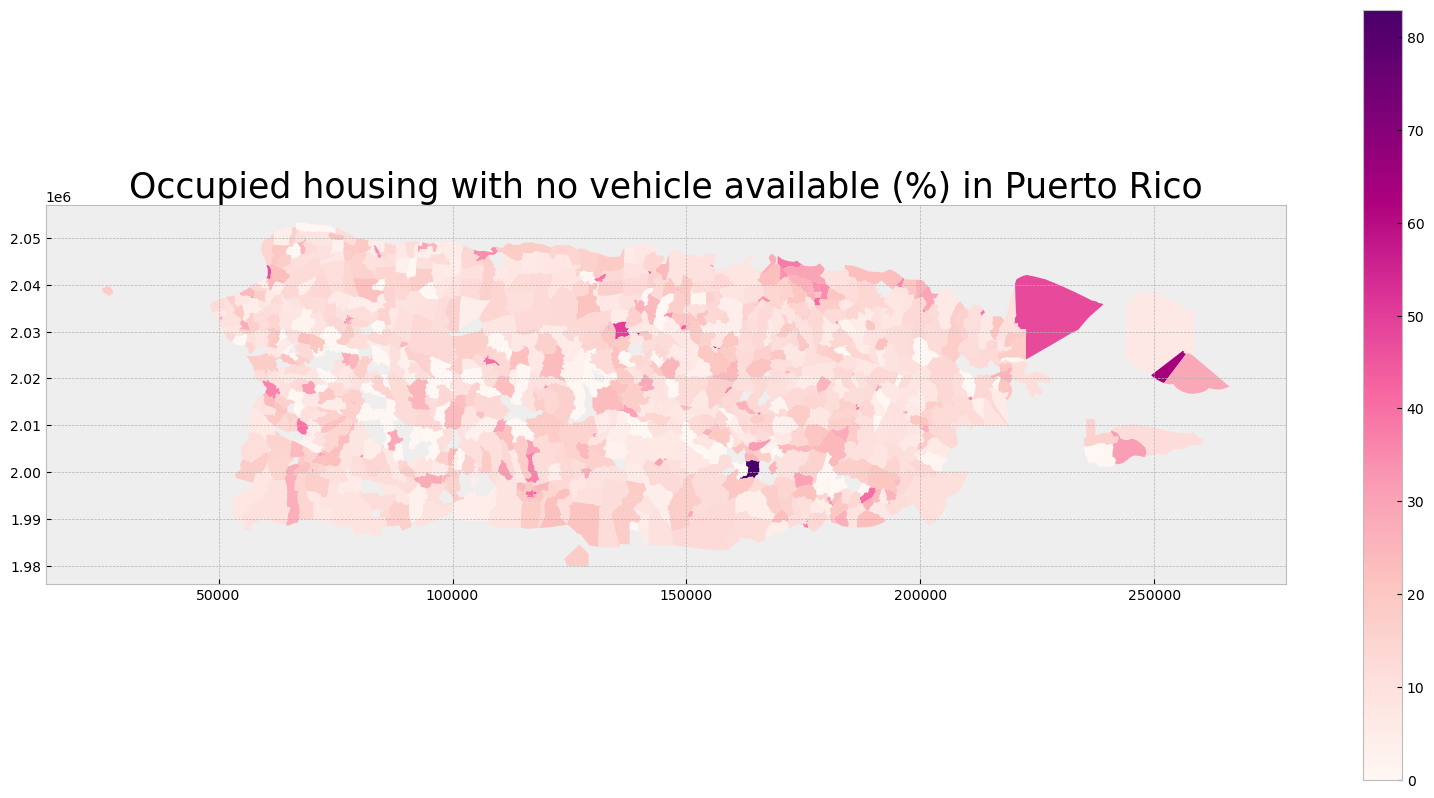

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

pr_merge.plot(column = "occ_housing_no_vehicle_pcnt",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Occupied housing with no vehicle available (%) in Puerto Rico', fontdict = {'fontsize': '25', 'fontweight' : '3'})

In [101]:
pr_merge['occ_housing_no_vehicle_pcnt'].describe()

count    845.000000
mean      13.938543
std        9.743685
min        0.000000
25%        7.611798
50%       12.505833
75%       18.181818
max       82.978723
Name: occ_housing_no_vehicle_pcnt, dtype: float64

<AxesSubplot: >

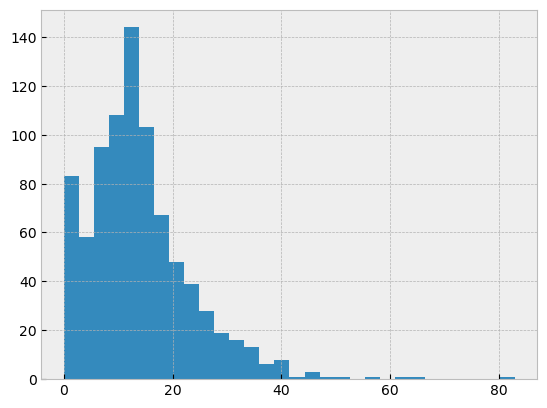

In [102]:
pr_merge['occ_housing_no_vehicle_pcnt'].hist(bins=30)

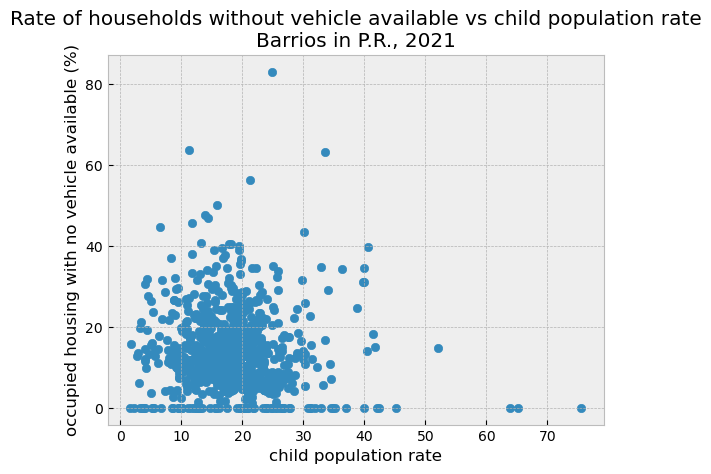

In [103]:
plt.scatter(pr_merge['chld_pop_pcnt'], pr_merge['occ_housing_no_vehicle_pcnt'])
plt.xlabel('child population rate')
plt.ylabel('occupied housing with no vehicle available (%)')
plt.title('Rate of households without vehicle available vs child population rate\nBarrios in P.R., 2021');

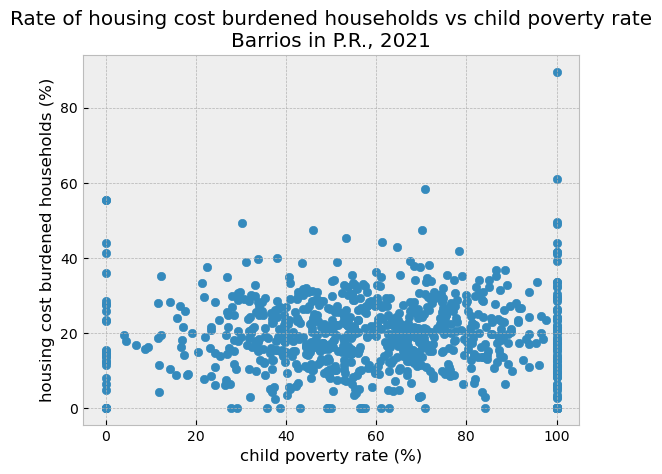

In [104]:
plt.scatter(pr_merge['chld_pov_pcnt'], pr_merge['housing_cost_burdened_pcnt'])
plt.xlabel('child poverty rate (%)')
plt.ylabel('housing cost burdened households (%)')
plt.title('Rate of housing cost burdened households vs child poverty rate\nBarrios in P.R., 2021');

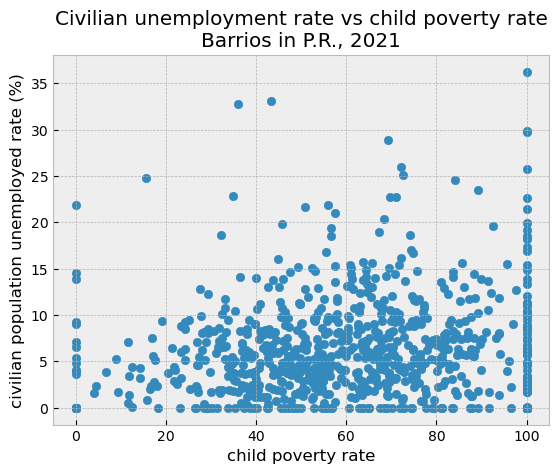

In [105]:
plt.scatter(pr_merge['chld_pov_pcnt'], pr_merge['unemployed_pcnt'])
plt.xlabel('child poverty rate')
plt.ylabel('civilian population unemployed rate (%)')
plt.title('Civilian unemployment rate vs child poverty rate\nBarrios in P.R., 2021');

### Improve horizontal bar plot with child population % in each NMEAD Operational Zone

What percentage of the Puerto Rican child population is in each NMEAD zone?

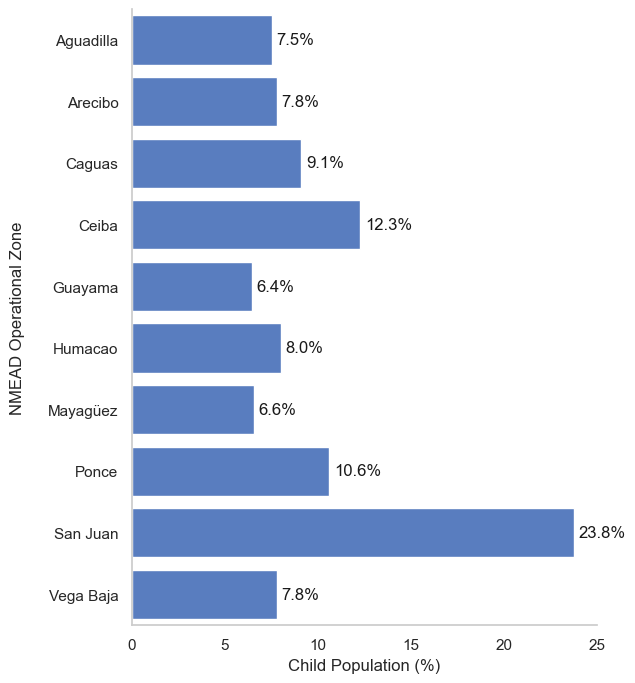

In [106]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))

# Load the variables at NMEAD operational zone level
chld_pop_rate = df4.copy(deep=True).reset_index()


# Plot the child population % data for all zones 
sns.set_color_codes("muted")
sns.barplot(x="pct chld pop", y="zone", data=chld_pop_rate,
            label="Population under 18 years of age (%)", color="b")

# Add a legend and informative axis label
#ax.legend(ncol=1, loc="lower right", frameon=True)

# Remove gridlines
ax.grid(False)
# Set axis labels and axis limits
ax.set(xlim=(0, 25), ylabel="NMEAD Operational Zone\n",
       xlabel="Child Population (%)")
# Add child population % values as text 
for i, v in enumerate(chld_pop_rate['pct chld pop']):
    ax.text(v+0.25, i, str(round(v,1))+'%', color='k', fontsize=12, ha='left', va='center')

sns.despine(left=False, bottom=False)

In [107]:
df_municipios.head(1)

GEOID                           NAME  total_pop  chld_pop  chld_pop_hh  \
0  72073  Jayuya Municipio, Puerto Rico      14877      3088         3088   

   chld_pop_pcnt  chld_pov_pcnt  chld_no_HI_pcnt  chld_dis_pcnt  \
0      20.756873      71.178756         3.925682      11.690415   

   chld_no_school_pcnt  grndprntHH_noprnt_pcnt  under18_oneprnt_pcnt  \
0             7.650273                0.712435             76.971389   

   chld_hh_cashasst_pcnt  chld_hh_no_internet_pcnt  chld_hh_no_comp_pcnt  \
0              78.400259                  8.452073             12.240933   

   unemployed_pcnt  occ_housing_no_vehicle_pcnt  occ_housing_crowding_pcnt  \
0         6.616319                     15.78737                   1.378897   

   housing_cost_burdened_pcnt  rank_pct_chld_pop  rank_pct_chld_pov  \
0                   20.283773           0.974359           0.884615   

   rank_pct_chld_no_HI  rank_pct_chld_dis  rank_pct_chld_no_school  \
0             0.730769           0.833333                 0.602564   

   rank_pct_grndprntHH_noprnt  rank_pct_under18_oneprnt  \
0                    0.153846                  0.987179   

   rank_pct_chld_hh_cashasst  rank_pct_chld_hh_no_internet  \
0                   0.987179                      0.705128   

   rank_pct_chld_hh_no_comp  rank_pct_unemployed  \
0                  0.794872             0.576923   

   rank_pct_occ_housing_no_vehicle  rank_pct_occ_housing_crowding  \
0                         0.769231                       0.192308   

   rank_pct_housing_cost_burdened  sum_of_all_rank_percentiles  CVI  \
0                        0.512821                     9.705128  1.0   

   sum_rp_thm1  index_thm1  sum_rp_thm2  index_thm2  sum_rp_thm3  index_thm3  \
0     4.025641    0.987179     3.628205    0.916667     2.051282    0.525641   

   flags  
0      3

### Inspect disttribution of CVI for municipios, barrios, and census tracts in all different NMEAD Operational Zones

In [108]:
df_municipios = get_municipio_names_and_zones(df_municipios, 'municipios')
df_barrios = get_municipio_names_and_zones(df_barrios, 'barrios')
df_census_tracts = get_municipio_names_and_zones(df_census_tracts, 'tracts')

In [109]:
variables

['chld_pop_pcnt',
 'chld_pov_pcnt',
 'chld_no_HI_pcnt',
 'chld_dis_pcnt',
 'chld_no_school_pcnt',
 'grndprntHH_noprnt_pcnt',
 'under18_oneprnt_pcnt',
 'chld_hh_cashasst_pcnt',
 'chld_hh_no_internet_pcnt',
 'chld_hh_no_comp_pcnt',
 'unemployed_pcnt',
 'occ_housing_no_vehicle_pcnt',
 'occ_housing_crowding_pcnt',
 'housing_cost_burdened_pcnt']

In [110]:
df_municipios = df_municipios[['municipio', 'zone', 'CVI'] + variables]
df_barrios = df_barrios[['municipio', 'zone', 'CVI'] + variables]
df_census_tracts = df_census_tracts[['municipio', 'zone', 'CVI'] + variables]

In [111]:
def create_CVI_distributions_by_geo_by_zone(geo):
    
    geo_to_df_dict = {'municipios': df_municipios, 
                      'barrios': df_barrios, 
                      'tracts': df_census_tracts}
    df = geo_to_df_dict[geo]
    
    zones = df['zone'].unique()

    for zone in zones:
        plt.figure()
        plt.hist(df[df['zone'] == zone]['CVI'])
        plt.title('CVI for {} in {} NMEAD Operational Zone'.format(geo, zone))
        plt.xlabel('CVI')
        plt.ylabel('number of {}'.format(geo))
        #plt.savefig('../../cvi-visualizations/cvi_distrib_{}_{}_NMEAD_zone.png'.format(geo, zone))

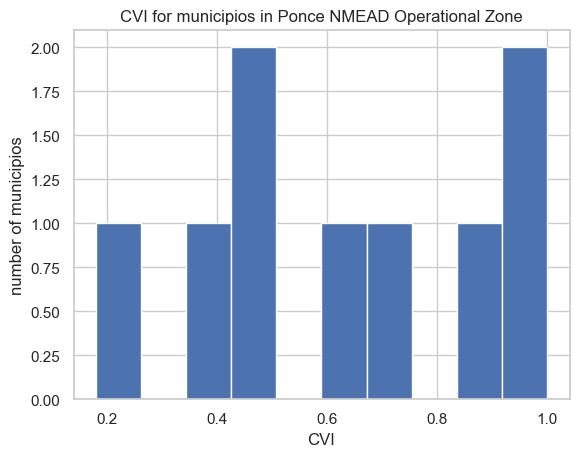

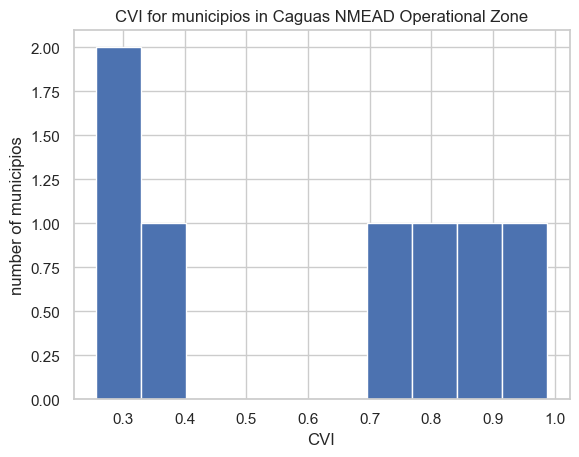

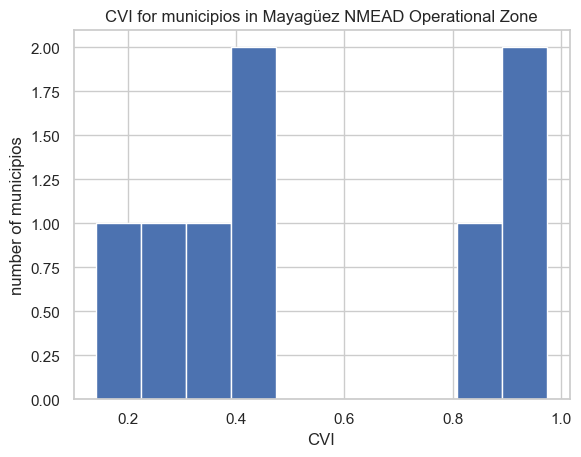

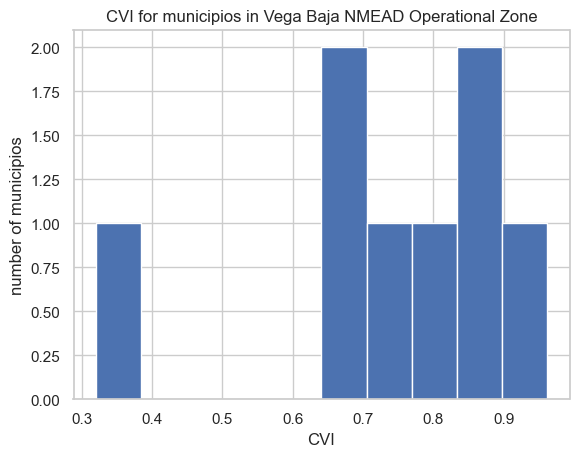

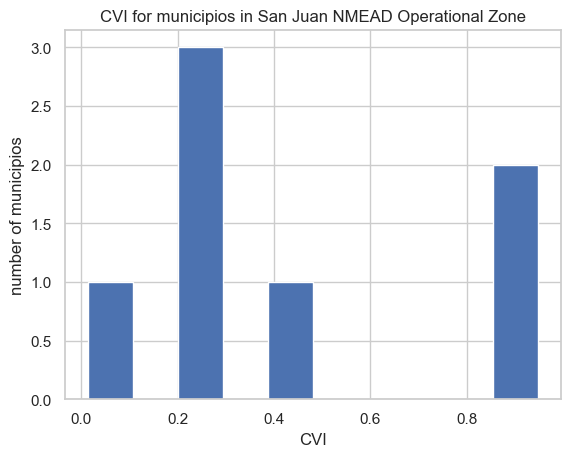

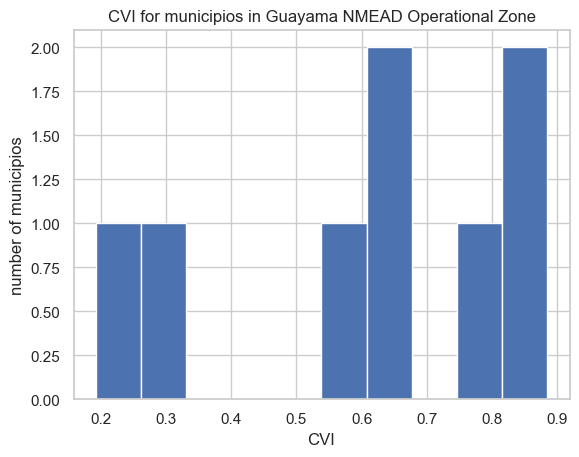

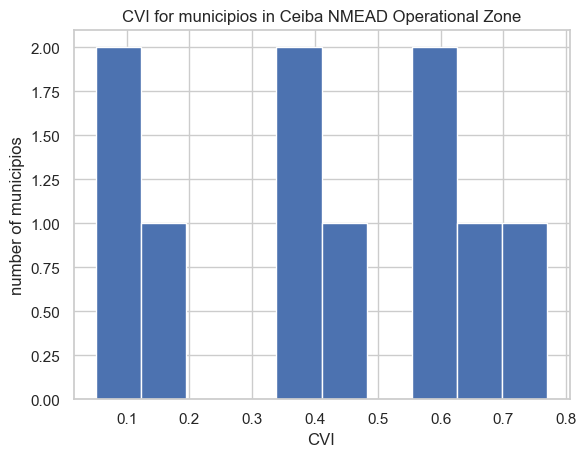

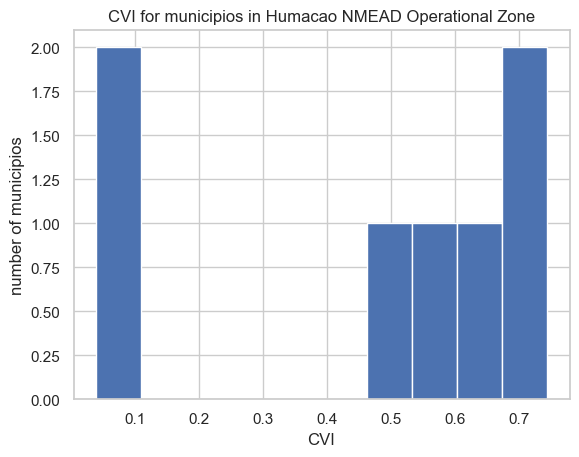

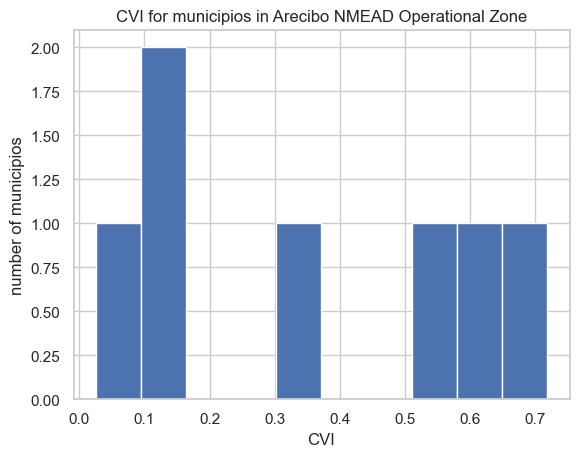

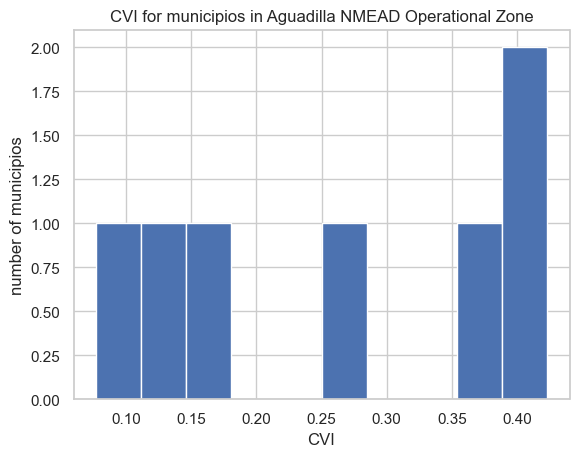

In [112]:
create_CVI_distributions_by_geo_by_zone('municipios')

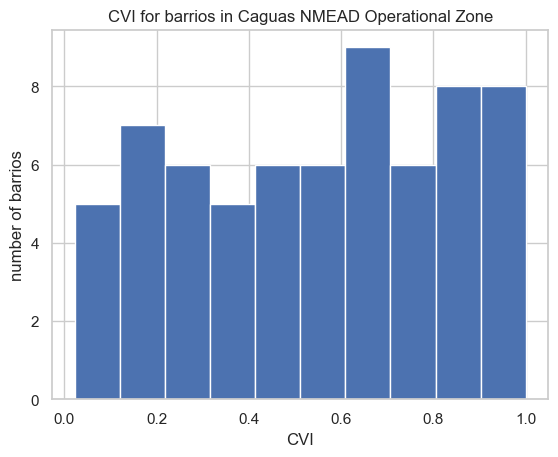

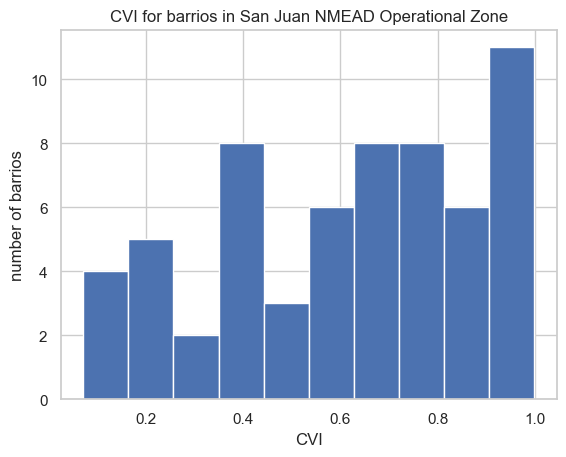

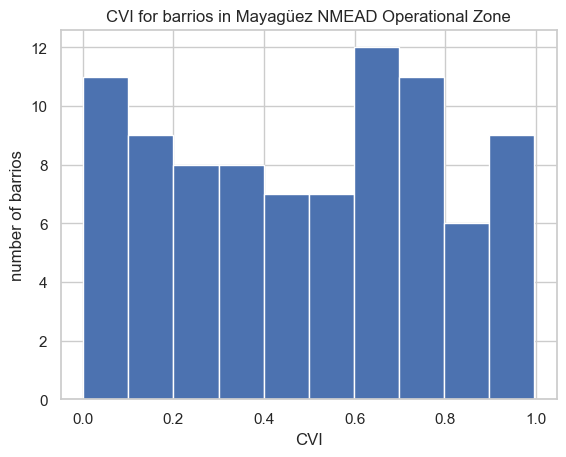

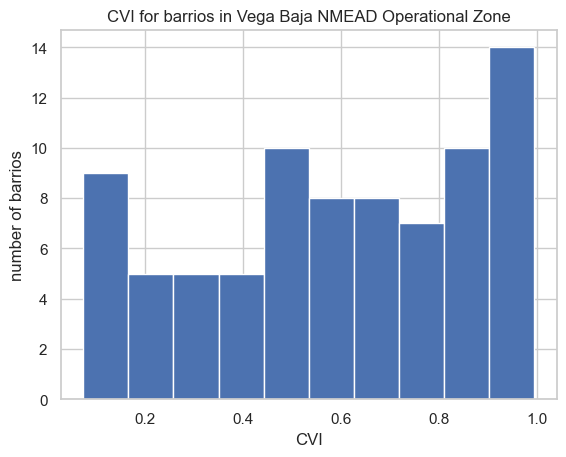

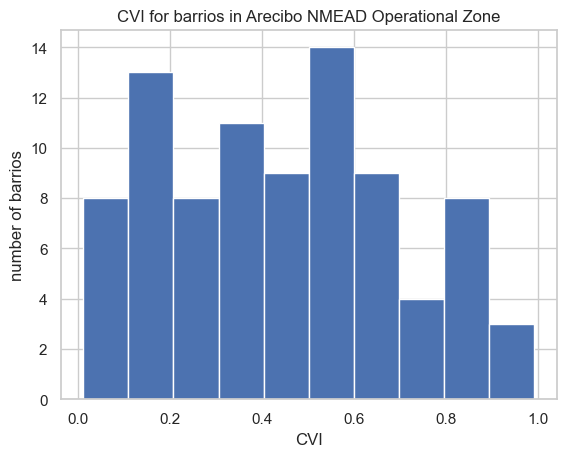

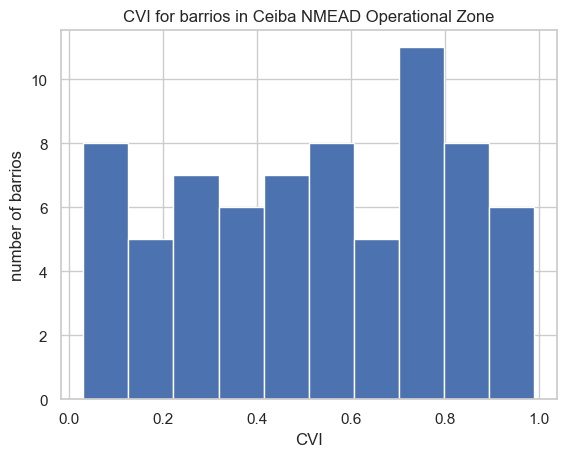

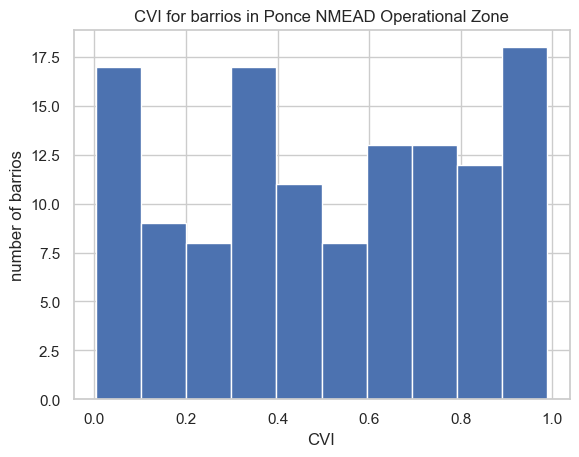

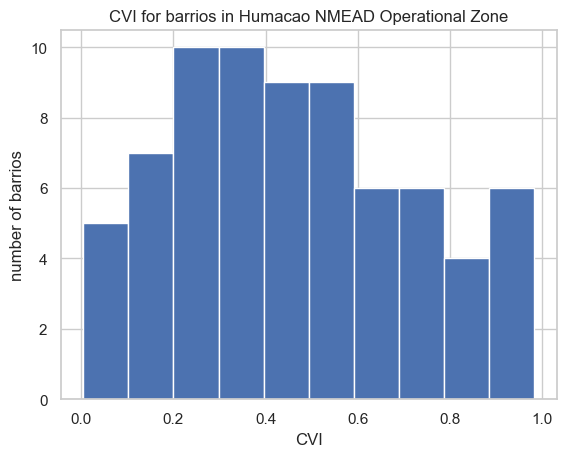

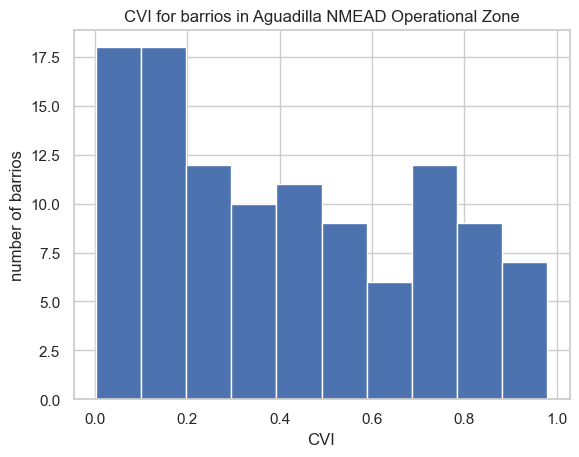

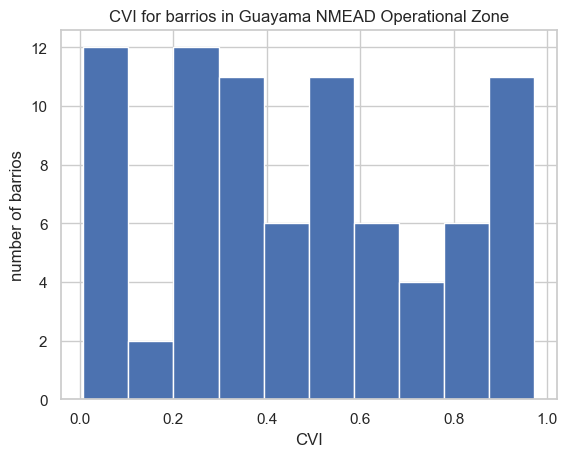

In [113]:
create_CVI_distributions_by_geo_by_zone('barrios')

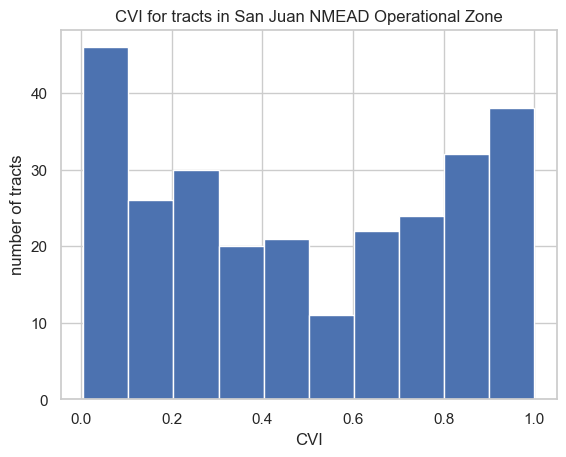

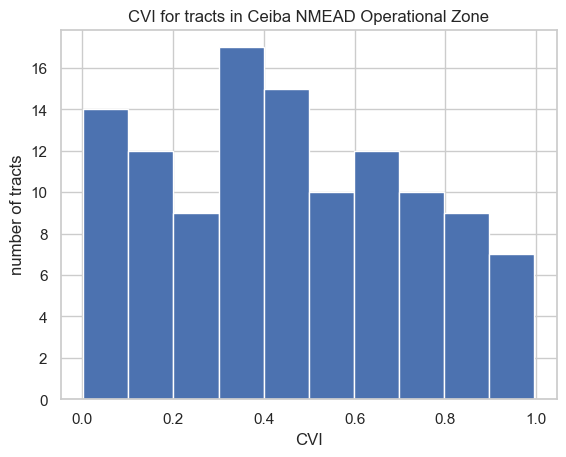

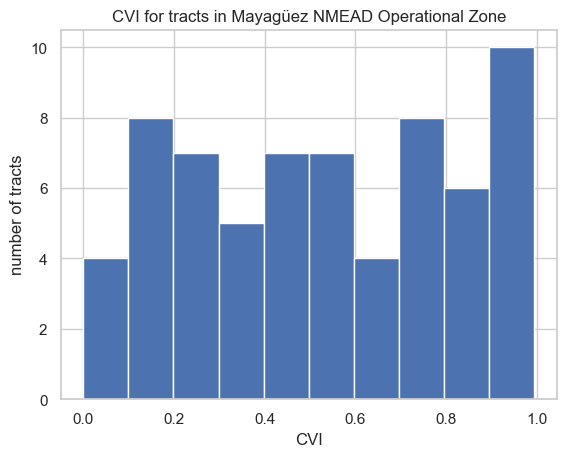

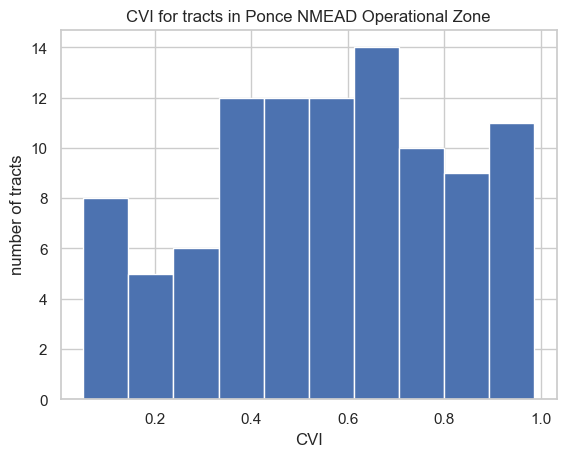

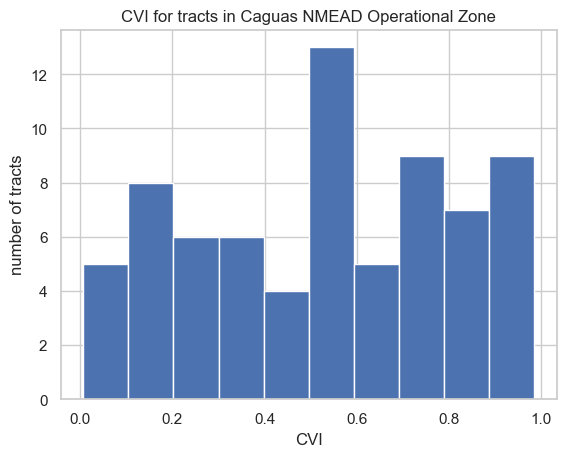

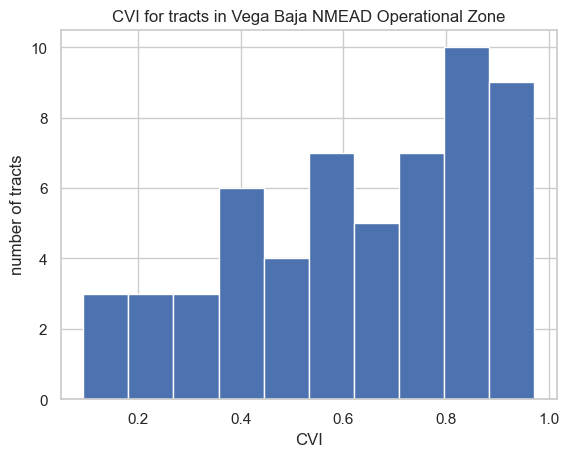

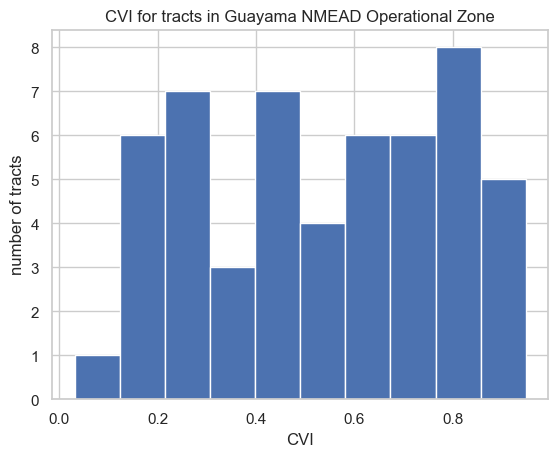

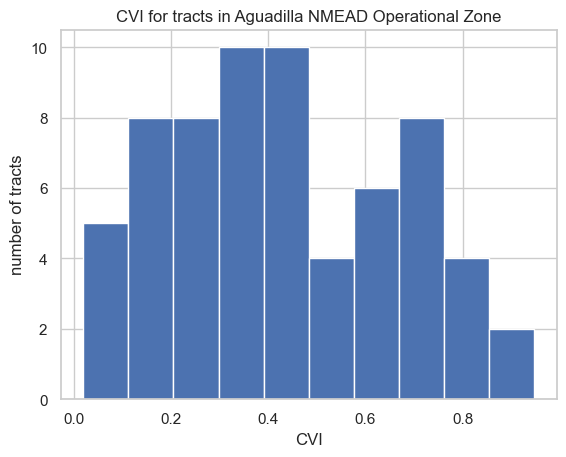

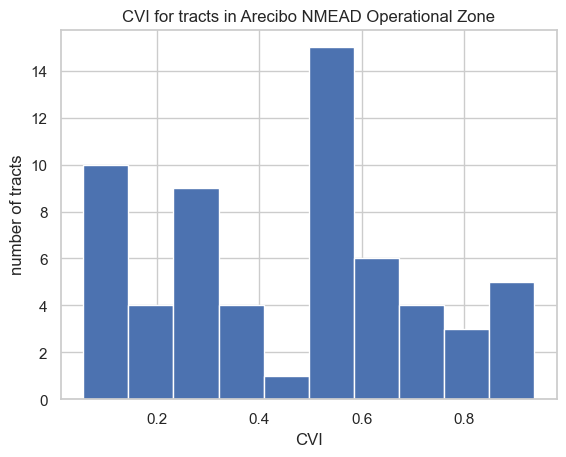

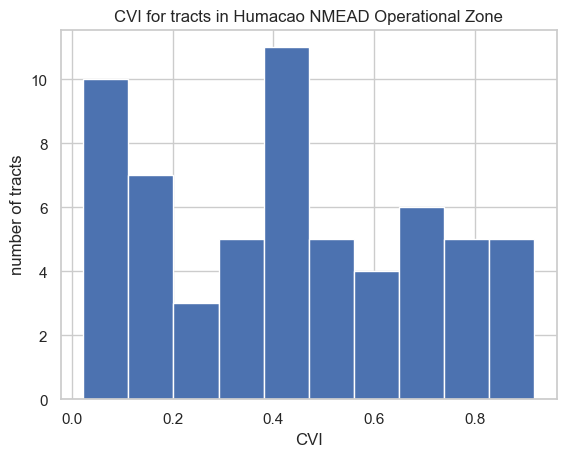

In [114]:
create_CVI_distributions_by_geo_by_zone('tracts')